2018 Edition<br>
*Claudio SCALZO and Luca LOMBARDO*

# Estimating Financial Risk through Monte Carlo Simulation
Risk analysis is part of every decision we make when faced with uncertainty, ambiguity, and variability. Indeed, even though we have unprecedented access to information, we can't accurately predict the future. In finance, there is a fair amount of uncertainty and risk involved with estimating the future value of financial products, due to the wide variety of potential outcomes. Monte Carlo simulation (also known as the Monte Carlo Method) allows inspecting many possible outcomes of the decision making process, and can be used to assess the impact of risk: this, in turns, allows for better decision-making under uncertainty.

## Goals
The main objectives we set for this Notebook are as follows:
1. Develop fundamental knowledge about Risk analysis
2. Understand Monte Carlo Simulation (MCS)
3. Apply Monte Carlo Simulation for predicting risk


## Steps
1. First, in section 1, we introduce the basics of MCS
2. In section 2, we work on a simple example to where we apply the MCS method
3. In section 3, we briefly summarize the main characteristics of the Monte Carlo Simulation (MCS) technique
4. In section 4, we overview the common distributions which are often used in MCS
5. In section 5, we work on a real use case, that focuses on estimating financial risk. We will use techniques such as featurization  (that is, generating additional features to improve model accuracy), linear regression, kernel density estimation, sampling distributions and so on ...

## Reference
This Notebook is inspired by Chapter 9 of the book [Advanced Analytics with Spark](http://shop.oreilly.com/product/0636920035091.do) by Josh Wills, Sandy Ryza, Sean Owen, and Uri Laserson. It is strongly suggested to read this Chapter to get a general idea of the topic of this Notebook.

# 1. Introduction

## 1.1. Monte Carlo Simulation (MCS)
Monte Carlo simulation is a computerized mathematical technique that can be applied such that it is possible to account for risk in quantitative analysis and decision making. This technique is used in many different fields, such as R&D, risk management, portfolio management, pricing derivatives, strategic planning, project planning, cost modeling and many more.

In general, MCS is a technique that "converts" uncertainty on input variables of a model into **probability distributions**. By combining the distributions and randomly selecting values from them, it recalculates the simulated model many times, to determine the probability of the output.

Historically, this technique was first used by scientists working on the atomic bomb: it was named after Monte Carlo, the Monaco resort town renowned for its casinos.  Since its introduction in World War II, Monte Carlo simulation has been used to model a variety of physical and conceptual systems.

## 1.2. How does it work?
Monte Carlo simulation performs risk analysis by building models of possible results by *substituting a range of possible input values, that constitute uncertainty, into a statistical distribution*. It then computes possible outcomes repeatedly, each time using a different set of random values from the probability functions that "model" the input. Depending upon the number of random input variables and their distribution, a Monte Carlo simulation could involve thousands or tens of thousands of "rounds" before it is complete. When complete, *Monte Carlo simulation produces distributions of possible outcome values*.

By using probability distributions instead of actual input samples, it is possible to model more accurately uncertainty: different choices of distributions will yield different outputs.

# 2. Illustrative example

Imagine you are the marketing manager for a firm that is planning to introduce a new product. You need to estimate the first-year net profit from this product, which might depend on:

- Sales volume in units
- Price per unit (also called "Selling price")
- Unit cost
- Fixed costs

Net profit will be calculated as $Net Profit = Sales Volume* (Selling Price - Unit cost) - Fixed costs$.  Fixed costs (accounting for various overheads, advertising budget, etc.) are known to be \$ 120,000, which we assume to be deterministic. All other factors, instead, involve some uncertainty: *sales volume* (in units) can cover quite a large range, the *selling price* per unit will depend on competitor actions, which are hard to predict, and *unit costs* will also vary depending on vendor prices and production experience, for example.

Now, to build a risk analysis model, we must first identify the uncertain variables -- which are essentially random variables.  While there's some uncertainty in almost all variables in a business model, we want to focus on variables where the range of values is significant.

## 2.1. Unit sales and unit price

Based on a hypothetical market research you have done, you have beliefs that there are equal chances for the market to be `slow`, `normal`, or `hot`:

- In a "slow" market, you expect to sell 50,000 units at an average selling price of \$11.00 per unit
- In a "normal" market, you expect to sell 75,000 units, but you'll likely realize a lower average selling price of \$10.00 per unit
- In a "hot" market, you expect to sell 100,000 units, but this will bring in competitors, who will drive down the average selling price to \$8.00 per unit

In [2]:
%%capture

# LIBRARIES IMPORT
import numpy as np
import random
from datetime import datetime
from datetime import timedelta
from itertools import islice
import matplotlib.patches as mpatches
%matplotlib inline
import statsmodels.api as sm
from os import listdir
from os.path import isfile, join
from scipy import stats
from scipy.stats import mode
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric.kde import KDEUnivariate
from IPython.display import display, HTML, display_html
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import scipy

! pip install matplotlib-venn
from matplotlib_venn import venn2

In [3]:
# FUNCTIONS TO DISPLAY HTML TABLES
def displayTable(table, header, title):
    print(title)
    display(HTML(pd.DataFrame(data=table, columns=header).to_html(index=False)))
    print()
    
def displaySideBySide(*tables, header, title):
    htmlStr = "<br><p style='text-align: left'>" + title + "</p>"
    for table in tables:
        htmlStr += pd.DataFrame(data=table, columns=header).to_html(index=False)
    display_html(htmlStr.replace('<table','<table style="float:left; margin-right: 20px"'), raw=True)
    print()

### Question 1
<div class="alert alert-info">
Calculate the average units and the unit price that you expect to sell, which depend on the market state. Use the assumptions above to compute the expected quantity of products and their expected unit price. 
</div>


In [4]:
# CALCULATE AVERAGE NUMBER OF UNITS AND AVERAGE PRICE PER UNIT
avgUnitsNumber = np.mean([50000, 75000, 100000])
avgUnitPrice = np.mean([11.0, 10.0, 8.0])

# PRINT THE INFORMATIONS
displayTable(np.matrix(avgUnitsNumber), ["Average number of units"], "")
displayTable(np.matrix(avgUnitPrice), ["Average price [$]"], "")

Average number of units
75000.0


Average price [$]
9.666667


## 2.2. Unit Cost

Another uncertain variable is Unit Cost. In our illustrative example, we assume that your firm's production manager advises you that unit costs may be anywhere from \$5.50 to \$7.50, with a most likely expected cost of \$6.50. In this case, the most likely cost can be considered as the average cost.

## 2.3. A Flawed Model: using averages to represent our random variables
Our next step is to identify uncertain functions -- also called functions of a random variable.  Recall that Net Profit is calculated as $Net Profit = Sales Volume * (Selling Price - Unit cost) - Fixed costs$.  However, Sales Volume, Selling Price and Unit Cost are all uncertain variables, so Net Profit is an uncertain function.

The simplest model to predict the Net Profit is using average of sales volume, average of selling price and average of unit cost for calculating. So, if only consider averages, we can say that the $Net Profit = 75,000*(9.66666666 - 6.5) - 120,000 \sim 117,500$.

However, as [Dr. Sam Savage](http://web.stanford.edu/~savage/faculty/savage/) warns, "Plans based on average assumptions will be wrong on average." The calculated result is far from the actual value: indeed, the **true average Net Profit** is roughly  \$93,000, as we will see later in the example.

### Question 2
#### Question 2.1
<div class="alert alert-info">
Write a function named `calNetProfit` to calculate the Net Profit using the average of sales volume, the average of selling price and the average of unit cost.
</div>

In [5]:
# FUNCTION TO CALCULATE THE NET PROFIT USING AVERAGES
def calNetProfit(unitsNumber, unitPrice, unitCost, fixedCost):
    return unitsNumber * (unitPrice - unitCost) - fixedCost

In [6]:
# CALCULATE AVERAGE COST PER UNIT AND TOTAL FIXED COST
avgUnitCost = 6.50
fixedCost = 120000

# CALCULATE THE NETPROFIT
netProfit = calNetProfit(avgUnitsNumber, avgUnitPrice, avgUnitCost, fixedCost)

# PRINT INFORMATIONS
displayTable(np.matrix(netProfit), ["Net profit [$]"], "")

Net profit [$]
117500.0


#### Question 2.2
<div class="alert alert-info">
Verify the warning message of Dr. Sam Savage by calculating the error of our estimated Net Profit using averages only. Recall that the true value is roughly \$93,000, so we are interested in:
<br>
$$ error = \frac{your\_value - true\_value}{true\_value}$$
<br>
Note also we are interested in displaying the error as a percentage.
<br>
Looking at the error we make, do you think that we can use the current model that only relies on averages?
</div>

In [7]:
# FUNCTION TO CALCULATE THE ERROR PERCENTAGE
def calculateError(calcValue, trueValue):
    
    # CALCULATE
    error = (calcValue - trueValue) / (trueValue)
    
    return error

In [8]:
# CALCULATE ERROR
error = calculateError(netProfit, 93000)

# SHOW
displayTable(np.matrix(error * 100), ["Net profit error [%]"], "")

Net profit error [%]
26.344086


<div class="alert alert-success">
As we clearly see from the result, the error is very high. An error that oscillates around the 26% is not a good index for our model: in this case, our result is totally in line with the Sam Savage's warning. We need another solution for our model. 
</div>

## 2.4. Using the Monte Carlo Simulation method to improve our model
As discussed before, the selling price and selling volume both depend on the state of the market scenario (slow/normal/hot). So, the net profit is the result of two random variables: `market scenario` (which in turn determines `sales volumes` and `selling price`) and `unit cost`.

Now, let's assume (this is an *a-priori* assumption we make) that `market scenario` follows a discrete, uniform distribution and that `unit cost` also follows a uniform distribution. Then, we can compute directly the values for selling price and selling volumes based on the outcome of the random variable `market scenario`, as shown in Section 2.1.

From these a-priori distributions, in each run (or trial) of our Monte Carlo simulation, we can generate the sample value for each random variable and use it to calculate the Net Profit. The more simulation runs, the more accurate our results will be. For example, if we run the simulation 100,000 times, the average net profit will amount to roughly \$92,600. Every time we run the simulation, a different prediction will be output: the average of such predictions will consistently be less than \$117,500, which we predicted using averages only.

Note also that in this simple example, we generate values for the `market scenario` and `unit cost` independently: we consider them to be **independent random variables**. This means that the eventual (and realistic!) correlation between the `market scenario` and `unit cost` variables is ignored. Later, we will learn how to be more precise and account for dependency between random variables.


### Question 3
#### Question 3.1
<div class="alert alert-info">
Write a function named `get_sales_volume_price` that returns the sales volume and price based on the market scenario. In particular, the scenario can get one of three values:
<ul>
  <li>0: Slow market</li>
  <li>1: Normal market</li>
  <li>2: Hot market</li>
</ul>  

The return value is a tuple in the form: `(sales_volume, price)`
</div>

In [9]:
# FUNCTION TO GET THE UNITS AND THE PRICE
# BASED ON THE MARKET SCENARIO
def getSalesVolumePrice(scenario):
    
    # SLOW MARKET
    if scenario == 0:
        return (50000, 11.0)
    
    # NORMAL MARKET
    elif scenario == 1:
        return (75000, 10.0)
    
    # HOT MARKET
    elif scenario == 2:
        return (100000, 8.0)
    
    else:
        print("Unsupported scenario value!")
        return (-1, -1.0)

#### Question 3.2
<div class="alert alert-info">
Run 100,000 Monte Carlo simulations and calculate the average net profit they produce. Then, compare the result to the "average model" we used in the previous questions (the one we called "flawed" model). Put your comments about the discrepancies between a simplistic model, and the more accurate MCS approach.<br>
<br>
Note that in each iteration, the `unit_cost` and `market_scenario` are generated according to their distributions. Also, recall what we have seen in Section 2.2: your firm account manager helped you with some research, to determine the variability of your random variables.<br>
<br>
<div class="label label-success">
HINT
</div>
<br>
Function `uniform(a,b)` in module `random` generates a number $a<=c<=b$, which is drawn from a uniform distribution.  

Function `randint(a,b)` helps you generating an integer number $a<=c<=b$.
</div>

In [10]:
# FUNCTION TO RUN THE MONTE CARLO SIMULATION
def mcs(numSimulations, fixedCost, costMin, costMax, seedValue):
    
    # INIT
    tests = []
    random.seed(seedValue)
    
    # SIMULATIONS LOOP
    for i in range(0, numSimulations):

        # RANDOM PARAMETERS
        unitCost = random.uniform(costMin, costMax)
        marketScenario = random.randint(0, 2)

        # GET THE UNITS NUMBER AND PRICE FOR THE SELECTED SCENARIO
        unitsNumber, unitPrice = getSalesVolumePrice(marketScenario)

        # CALCULATE NET PROFIT
        netProfit = calNetProfit(unitsNumber, unitPrice, unitCost, fixedCost)
        tests.append(netProfit)
    
    # CALCULATE AVERAGE
    avgNetProfit = np.mean(tests)
    
    return avgNetProfit

In [11]:
# RUN MONTE CARLO SIMULATION
netProfit = mcs (
    numSimulations = 100000,             # the number of simulation to compute
    fixedCost = 120000,                  # the total fixed cost
    costMin = 5.5,                       # minumum unit cost
    costMax = 7.5,                       # maximum unit cost
    seedValue = datetime.now()           # seed value for the function 'random.seed' called inside the mcs
)

# CALCULATE ERROR
error = calculateError(netProfit, 93000)

# SHOW
displayTable(np.matrix(netProfit), ["Average net profit [$]"], "")
displayTable(np.matrix(error * 100), ["Net profit error [%]"], "")

Average net profit [$]
92435.45385


Net profit error [%]
-0.607039


<div class="alert alert-success">
Thanks to the Monte Carlo method the profit error is extremely better than before! The error stays (in absolute value) around the 0.2%-0.3%, that compared to the 26% obtained with the simple averages, is better without any doubt.<br>
<br>
We can now try to see how the results react to the number of simulation of the Monte Carlo method, which is the main hyperparameter we need to set before running the simulation.<br>
It's **important to notice** that we *don't* need to run *n* times the Monte Carlo simulation, with a value that grows from 1 to *n*. The results obtained with the previous iterations (for example the iteration number 5) can be reused for the next iteration (for example the iteration number 6): it's enough to add the netProfit to an accumulator and then compute just the new mean at each iteration. Let's see the code:
</div>

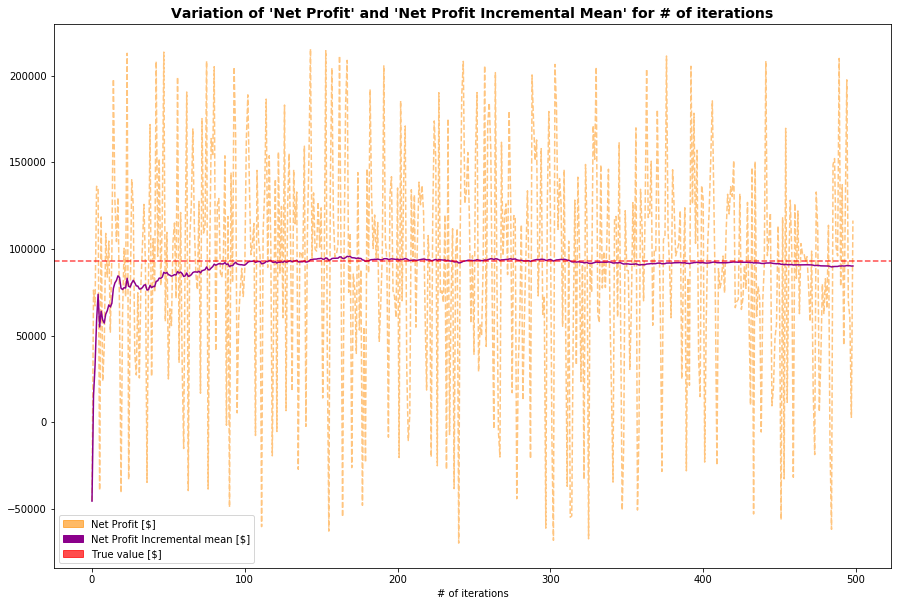

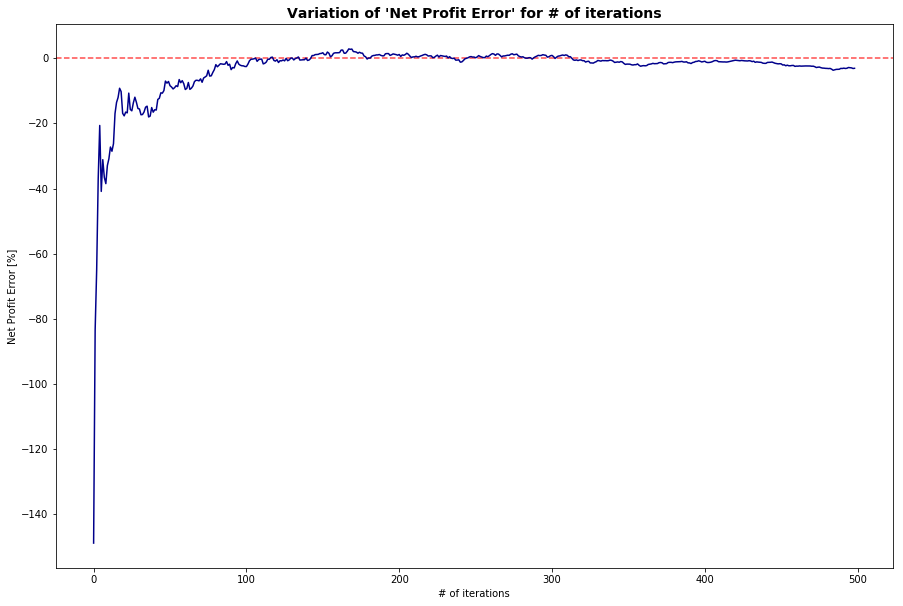

In [12]:
profits = []
errors = []
means = []
numIterations = 500

# RUN MONTE CARLO SIMULATION FOR A LOT OF TIMES WITH DIFFERENT NUMBER OF SIMULATIONS
for i in range(1, numIterations):
    
    # RUN MONTE CARLO SIMULATION SINGLE TIME
    netProfit = mcs (
        numSimulations = 1,                  # the number of simulation to compute (in this case just one!)
        fixedCost = 120000,                  # the total fixed cost
        costMin = 5.5,                       # minumum unit cost
        costMax = 7.5,                       # maximum unit cost
        seedValue = datetime.now()           # seed value for the function 'random.seed' called inside the mcs
    )
    
    # APPEND THE SINGLE TEST ('netProfit') TO THE 'profits' LIST
    profits.append(netProfit)
    
    # CALCULATE ERROR ON THE 'INCREMENTAL' TESTS LIST
    errors.append(calculateError(np.mean(profits), 93000) * 100)
    
    # CALCULATE MEAN AND APPEND IT TO THE 'INCREMENTAL' MEANS LIST
    means.append(np.mean(profits))

# PLOT THE RESULTS
iterations = [x for x in range(0, numIterations-1)]
plt.figure(figsize=(15,10))
plt.xlabel("# of iterations")
plt.plot(iterations, profits, color="darkorange", linestyle='--', alpha=0.5)
plt.plot(iterations, means, color="darkmagenta")
plt.axhline(y=93000, color='r', linestyle='--', alpha=0.7)
red_patch = mpatches.Patch(color='red', label='True value [$]', alpha=0.7)
magenta_patch = mpatches.Patch(color='darkmagenta', label='Net Profit Incremental mean [$]')
orange_patch = mpatches.Patch(color='darkorange', label='Net Profit [$]', alpha=0.6)
plt.legend(handles=[orange_patch, magenta_patch, red_patch])
plt.title("Variation of 'Net Profit' and 'Net Profit Incremental Mean' for # of iterations", weight="semibold", fontsize="14")
plt.show()

plt.figure(figsize=(15,10))
plt.xlabel("# of iterations")
plt.ylabel("Net Profit Error [%]")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
plt.plot(iterations, errors, color="darkblue")
plt.title("Variation of 'Net Profit Error' for # of iterations", weight="semibold", fontsize="14")
plt.show()

<div class="alert alert-success">
It's clear from the plot that the result immediately converges to an error! Around 1000 iterations are enough for the Monte Carlo Simulation (on this dataset) to stabilize on the error value that we've obtained with a lot more loops (100000) in the previous test.
</div>


# 3. A brief summary of the Monte Carlo Simulation (MCS) technique

- A MCS allows several inputs to be used at the same time to compute the probability distribution of one or more outputs
- Different types of probability distributions can be assigned to the inputs of the model, depending on any *a-priori* information that is available. When the distribution is completely unknown, a common technique is to use a distribution computed by finding the best fit to the data you have
- The MCS method is also called a **stochastic method** because it uses random variables. Note also that the general assumption is for input random variables to be independent from each other. When this is not the case, there are techniques to account for correlation between random variables.
- A MCS generates the output as a range instead of a fixed value and shows how likely the output value is to occur in that range. In other words, the model outputs a probability distribution.

# 4. Common distributions used in MCS
In what follows, we summarize the most common probability distributions that are used as *a-priori* distributions for input random variables:

- ***Normal/Gaussian Distribution***: this is a continuous distribution applied in situations where the mean and the standard deviation of a given input variable are given, and the mean represents the most probable value of the variable. In other words, values "near" the mean are most likely to occur.  This is symmetric distribution, and it is not bounded in its co-domain. It is very often used to  describe **natural phenomena, such as people’s heights, inflation rates, energy prices**, and so on and so forth. An illustration of a normal distribution is given below:
![normal_distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Normal_Distribution_PDF.svg/320px-Normal_Distribution_PDF.svg.png)

- ***Lognormal Distribution***: this is a distribution which is appropriate for variables taking values in the range $[0, \infty]$. Values are positively skewed, not symmetric like a normal distribution.  Examples of variables described by some lognormal distributions include, for example, **real estate property values, stock prices, and oil reserves**. An illustration of a lognormal distribution is given below:
![log_normal_distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/PDF-log_normal_distributions.svg/320px-PDF-log_normal_distributions.svg.png) 

- ***Triangular Distribution***: this is a continuous distribution with fixed minimum and maximum values. It is bounded by the minimum and maximum values and can be either symmetrical (the most probable value = mean = median) or asymmetrical. Values around the most likely value (e.g. the mean) are more likely to occur.  Variables that could be described by a triangular distribution include, for example, **past sales history per unit of time and inventory levels**. An illustration of a triangular distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Triangular_distribution_PMF.png/320px-Triangular_distribution_PMF.png)

- ***Uniform Distribution***: this is a continuous distribution bounded by known minimum and maximum values. In contrast to the triangular distribution, the likelihood of occurrence of the values between the minimum and maximum is the same. In other words, all values have an equal chance of occurring, and the distribution is simply characterized by the minimum and maximum values. Examples of variables that can be described by a uniform distribution include **manufacturing costs or future sales revenues for a new product**. An illustration of the uniform distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Uniform_Distribution_PDF_SVG.svg/320px-Uniform_Distribution_PDF_SVG.svg.png)

- ***Exponential Distribution***: this is a continuous distribution used to model **the time that pass between independent occurrences**, provided that the rate of occurrences is known. An example of the exponential distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Exponential_pdf.svg/320px-Exponential_pdf.svg.png)

- ***Discrete Distribution*** : for this kind of distribution, the "user" defines specific values that may occur and the likelihood of each of them.  An example might be the **results of a lawsuit: 20% chance of positive verdict, 30% change of negative verdict, 40% chance of settlement, and 10% chance of mistrial**.


# 5. A real use case: estimating the financial risk of a portfolio of stocks
We hope that by now you have a good understanding about Monte Carlo simulation. Next, we apply this method to a real use case: *financial risk estimation*.

Imagine that you are an investor on the stock market. You plan to buy some stocks and you want to estimate the maximum loss you could incur after two weeks of investing. This is the quantity that the financial statistic "Value at Risk" (VaR) seeks to measure. [VaR](https://en.wikipedia.org/wiki/Value_at_risk) is defined as a measure of investment risk that can be used as a reasonable estimate of the maximum probable loss for a value of an investment portfolio, over a particular time period. A VaR statistic depends on three parameters: a portfolio, a time period, and a confidence level. A VaR of 1 million dollars with a 95% confidence level over two weeks, indicates the belief that the portfolio stands only a 5% chance of losing more than 1 million dollars over two weeks. VaR has seen widespread use across financial services organizations. This statistic plays a vital role in determining how much cash investors must hold to meet the credit ratings that they seek. In addition, it is also used to understand the risk characteristics of large portfolios: it is a good idea to compute the VaR before executing trades, such that it can help take informed decisions about investments. 

Our goal is calculating VaR of two weeks interval with 95% confidence level and the associated [VaR confidence interval](http://www.investopedia.com/ask/answers/041615/whats-difference-between-confidence-level-and-confidence-interval-value-risk-var.asp).


## 5.1. Terminology
In this use case, we will use some terms that might require a proper definition, given the domain. This is what we call the *Domain Knowledge*.

- **Instrument**: A tradable asset, such as a bond, loan, option, or stock investment. At any particular time, an instrument is considered to have a value, which is the price for which it can be sold. In the use case of this notebook, instruments are stock investments.
- **Portfolio**: A collection of instruments owned by a financial institution. 
- **Return**: The change in an instrument or portfolio’s value over a time period. 
- **Loss**: A negative return. 
- **Index**: An imaginary portfolio of instruments. For example, the NASDAQ Composite index includes about 3,000 stocks and similar instruments for major US and international companies. 
- **Market factor**: A value that can be used as an indicator of macro aspects of the financial climate at a particular time. For example, the value of an index, the Gross Domestic Product of the United States, or the exchange rate between the dollar and the euro. We will often refer to market factors as just factors.

## 5.2. The context of our use case
We have a list of instruments that we plan to invest in. The historical data of each instrument has been collected for you. For simplicity, assume that the returns of instruments at a given time, depend on 4 market factors only: 

- GSPC value
- IXIC value 
- The return of crude oil
- The return of treasury bonds

Our goal is building a model to predict the loss after two weeks' time interval with confidence level set to 95%.

As a side note, it is important to realize that the approach presented in this Notebook is a simplified version of what would happen in a real Financial firm. For example, the returns of instruments at a given time often depend on more than 4 market factors only! Moreover, the choice of what constitute an appropriate market factor is an art!



## 5.3. The Data
The stock data can be downloaded (or scraped) from Yahoo! by making a series of REST calls. The data includes multiple files. Each file contains the historical information of each instrument that we want to invest in. The data is in the following format (with some samples):
```
Date, Open, High, Low, Close, Volume, Adj Close
2016-01-22,66.239998,68.07,65.449997,67.860001,137400,67.860001
2016-01-21,65.410004,66.18,64.459999,65.050003,148000,65.050003
2016-01-20,64.279999,66.32,62.77,65.389999,141300,65.389999
2016-01-19,67.720001,67.989998,64.720001,65.379997,178400,65.379997
```

The data of GSPC and IXIC values (our two first market factors) are also available on Yahoo! and use the very same format. 

The crude oil and treasure bonds data is collected from investing.com, and has a different format, as shown below (with some samples):
```
Date    Price   Open    High    Low     Vol.    Change %
Jan 25, 2016    32.17   32.36   32.44   32.10   -       -0.59%
Jan 24, 2016    32.37   32.10   32.62   31.99   -       0.54%
Jan 22, 2016    32.19   29.84   32.35   29.53   -       9.01%
Jan 21, 2016    29.53   28.35   30.25   27.87   694.04K 11.22%
Jan 20, 2016    26.55   28.33   28.58   26.19   32.11K  -6.71%
Jan 19, 2016    28.46   29.20   30.21   28.21   188.03K -5.21%
```

In our use case, the factors' data will be used jointly to build a statistical model: as a consequence, we first need to preprocess the data to proceed.

## 5.4. Data preprocessing
In this Notebook, all data files have been downloaded for you, such that you can focus on pre-processing. Next, we will:

  - Read the factor data files which are in two different formats, process and merge them together
  - Read the stock data and pre-process it
  - Trim all data into a specific time region
  - Fill in the missing values
  - Generate the data of returns in each two weeks' time interval window
  
### Factor data pre-processing

We need two functions to read and parse data from Yahoo! and Investing.com respectively. We are interested only in information about the time and the corresponding returns of a factor or an instrument: as a consequence, we will project away many columns of our RAW data, and keep only the information we are interested in.

The 3000-instrument and the 4-factor history are small enough to be read and processed locally: we do not need to use the power of parallel computing to proceed. Note that this is true also for larger cases with hundreds of thousands of instruments and thousands of factors. The need for a distributed system like Spark comes in when actually **running** the Monte Carlo simulations, which can require massive amounts of computation on each instrument. 

<div class="alert alert-success">
It is important to notice that in this case the header of data provided by the two services is slightly different one from each other. We have to pay attention to choose from each of them a coherent attribute otherwise it could affect badly our whole analysis. We've decided to work with the <b><i>close price</i></b> of the stocks: in the <i>Yahoo!</i> dataset is simply called 'close' but in the <i>investing.com</i> dataset is called 'price'.
</div>

### Question 4
#### Question 4.1
<div class="alert alert-info">
Write a function named `readInvestingDotComHistory` to parse data from investing.com based on the format specified above (see Section 5.3). Recall that we use two factors here: one that is related to the price of crude oil, one that is related to some specific US bonds. 

<br>

Print the first 5 entries of the first factor (crude oil price) in the parsed data.

<br>

Note that we are only interested in the date and price of stocks.<br>
<br>
<div class="label label-success">HINT</div>  
You can parse a string to `datetime` object by using the function `strptime(<string>, <dtime_format>)`. In this case, the datetime format is `"%b %d, %Y"`. For more information, please follow this [link](https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior).
</div>

In the next cell, we simply copy data from our HDFS cluster (that contains everything we need for this Notebook) to the instance (a Docker container) running your Notebook. This means that you will have "local" data that you can process without using Spark. Note the folder location: find and verify that you have correctly downloaded the files!

In [13]:
! [ -d monte-carlo-risk ] || (echo "Downloading prepared data from HDFS. Please wait..." ; hdfs dfs -copyToLocal /datasets/monte-carlo-risk . ; echo "Done!";)

In [14]:
baseFolder = "monte-carlo-risk/"
factorsFolder = baseFolder + "factors/"

# FUNCTION TO READ THE .tsv FILES
def readInvestingDotComHistory(fname):
    
    def processLine(line):
        cols = line.split("\t")
        date = datetime.strptime(cols[0], "%b %d, %Y")
        value = float(cols[1])
        return (date, value)
    
    with open(fname) as f:
        content = f.readlines()[:0:-1] # reverse order (ascending date)
        return list(map(processLine, content))

In [15]:
# LIST ALL FILES
factor1files = map(lambda fn: factorsFolder + fn, ['crudeoil.tsv', 'us30yeartreasurybonds.tsv'])

# PROCESS EACH FILE
factors1 = [readInvestingDotComHistory(f) for f in factor1files]

# PRINT THE FIRST AND LAST 5 RESULTS FOR BOTH FACTORS
displaySideBySide(factors1[0][:5], factors1[0][-5:],
                  header=["Date", "Close price"],
                  title="First 5 and Last 5 results (for the Crude Oil factor):")

displaySideBySide(factors1[1][:5], factors1[1][-5:],
                  header=["Date", "Close price"],
                  title="First 5 and Last 5 results (for the US Bonds):")

Date,Close price
2006-01-26,66.26
2006-01-27,67.76
2006-01-30,68.35
2006-01-31,67.92
2006-02-01,66.56
Date,Close price
2016-01-20,26.55
2016-01-21,29.53
2016-01-22,32.19
2016-01-24,32.37


Date,Close price
2008-02-12,4.457
2008-02-13,4.540
2008-02-14,4.654
2008-02-15,4.582
2008-02-19,4.665
Date,Close price
2016-01-20,2.758
2016-01-21,2.809
2016-01-22,2.828
2016-01-24,2.827


<div class="alert alert-success">
Now we can graphically show the factor's movements over time:
</div>

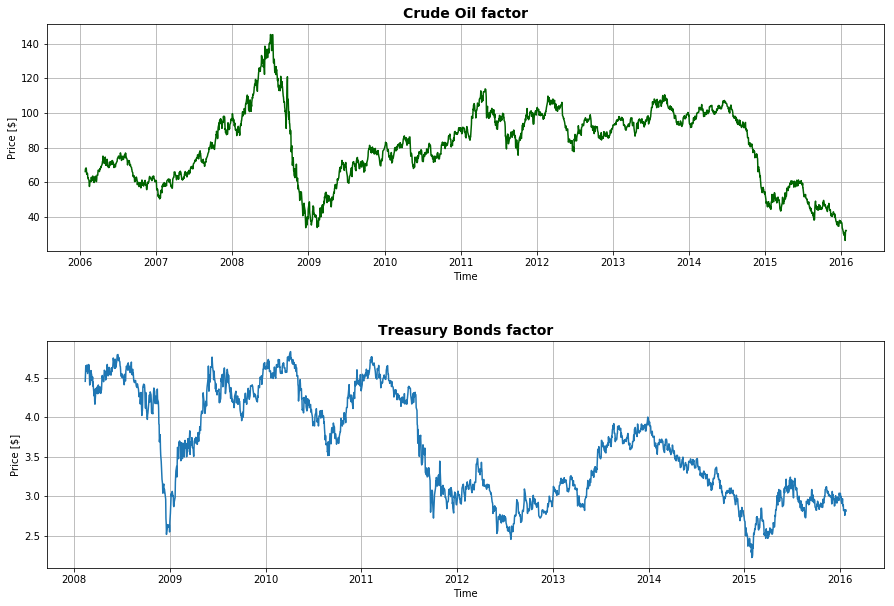

In [16]:
# CRUDE OIL
plt.figure(figsize=(15,10))
dates, values = zip(*factors1[0][:])
plt.subplot(2,1,1)
plt.title("Crude Oil factor", weight="semibold", fontsize="14")
plt.xlabel("Time")
plt.ylabel("Price [$]")
plt.grid()
plt.plot(dates, values, color="darkgreen")

# TREASURY BONDS
dates, values = zip(*factors1[1][:])
plt.subplot(2,1,2)
plt.title("Treasury Bonds factor", weight="semibold", fontsize="14")
plt.xlabel("Time")
plt.ylabel("Price [$]")
plt.grid()
plt.plot(dates, values)

# SHOW
plt.subplots_adjust(hspace = 0.4)
plt.show()

<div class="alert alert-success">
These factors follow a very irregular evolution but, in general, it seems that their value has diminished over time.
</div>

Now, the data structure `factors1` is a list, containing data that pertains to two (out of a total of four) factors that influence the market, as obtained by investing.com. Each element in the list is a tuple, containing some sort of timestamp, and the value of one of the two factors discussed above. From now on, we call these elements "**records**" or "**entries**". Visually, `factors1` looks like this:

| 0 (crude oil) | 1 (US bonds)|
| --- | --- |
| time_stamp, value | time_stamp, value |
| ... | ... |
| time_stamp, value | time_stamp, value |
| ... | ... |


#### Question 4.2
<div class="alert alert-info">
Write a function named `readYahooHistory` to parse data from yahoo.com based on its format, as described in Section 5.3.  
<ul></ul>
Print the first 5 entries of the first factor (namely GSPC). Comment the time range of the second batch of data we use in our Notebook.  
<ul></ul>

Note that we are only interested in the date and price of stocks.<br>
<br>
<div class="label label-danger">NOTE</div> The datetime format now is in a different format than the previous one.<br>

<div class="label label-success">HINT</div> Use a terminal (or put the bash commands inline in your Notebook) to list filenames in your local working directory to find and have a look at your local files.

</div>

In [17]:
# FUNCTION TO READ THE .csv FILES
def readYahooHistory(fname):
    
    def processLine(line):
        cols = line.split(",")
        date = datetime.strptime(cols[0], "%Y-%m-%d")
        value = float(cols[4])
        return (date, value)

    with open(fname) as f:
        content = f.readlines()[:0:-1] # reverse order (ascending date)
        return list(map(processLine, content))

In [18]:
# LIST ALL FILES
factor2Files = map(lambda fn: factorsFolder + fn, ['GSPC.csv', 'IXIC.csv'])

# PROCESS EACH FILE
factors2 = [readYahooHistory(f) for f in factor2Files]

# PRINT THE FIRST AND LAST 5 RESULTS
displaySideBySide(factors2[0][:5], factors2[0][-5:],
                  header=["Date", "Close price"],
                  title="First 5 and Last 5 results (for the GSPC factor):")

displaySideBySide(factors2[1][:5], factors2[1][-5:],
                  header=["Date", "Close price"],
                  title="First 5 and Last 5 results (for the IXIC factor):")

Date,Close price
1950-01-03,16.66
1950-01-04,16.85
1950-01-05,16.93
1950-01-06,16.98
1950-01-09,17.08
Date,Close price
2016-01-15,1880.329956
2016-01-19,1881.329956
2016-01-20,1859.329956
2016-01-21,1868.989990


Date,Close price
1971-02-05,100.000000
1971-02-08,100.839996
1971-02-09,100.760002
1971-02-10,100.690002
1971-02-11,101.449997
Date,Close price
2016-01-15,4488.419922
2016-01-19,4476.950195
2016-01-20,4471.689941
2016-01-21,4472.060059


<div class="alert alert-success">
The data obtained analyzing the *Yahoo.com* history are obviously different from the ones of *Investing.com*. The last ones start from *March 1, 1950* while the data obtained from *Investing.com* start from the 2006!<br>
<br>
Now we can graphically show the movements of the factors:
</div>

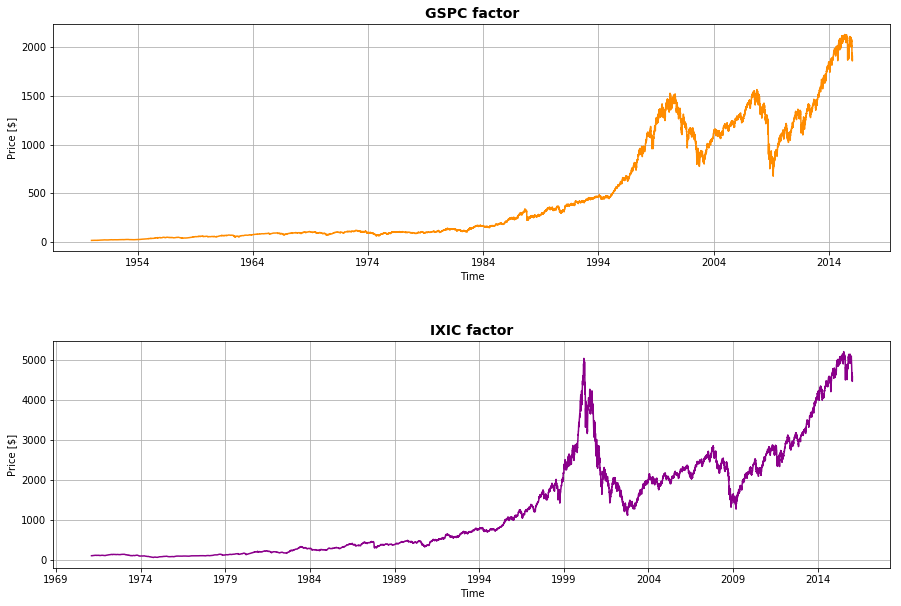

In [19]:
# GSPC
plt.figure(figsize=(15,10))
dates, values = zip(*factors2[0][:])
plt.subplot(2,1,1)
plt.title("GSPC factor", weight="semibold", fontsize="14")
plt.xlabel("Time")
plt.ylabel("Price [$]")
plt.grid()
plt.plot(dates, values, color="darkorange")

# IXIC
dates, values = zip(*factors2[1][:])
plt.subplot(2,1,2)
plt.title("IXIC factor", weight="semibold", fontsize="14")
plt.xlabel("Time")
plt.ylabel("Price [$]")
plt.grid()
plt.plot(dates, values, color="darkmagenta")

# SHOW
plt.subplots_adjust(hspace = 0.4)
plt.show()

<div class="alert alert-success">
The price value of these two factors is increasing very rapidly over time. This is an opposite behaviour compared to the one of the two previous factors (Crude Oil and Treasury Bonds).
</div>

Now, the data structure `factors2` is again list, containing data that pertains to the next two (out of a total of four) factors that influence the market, as obtained by Yahoo!. Each element in the list is a tuple, containing some sort of timestamp, and the value of one of the two factors discussed above. Visually, `factors2` looks like this:

| 0 (GSPC) | 1 (IXIC)|
| --- | --- |
| time_stamp, value | time_stamp, value |
| ... | ... |
| time_stamp, value | time_stamp, value |
| ... | ... |


### Stock data pre-processing

Next, we prepare the data for the instruments we consider in this Notebook (i.e., the stocks we want to invest in). 

#### Question 4.3

<div class="alert alert-info">
In this Notebook, we assume that we want to invest on the first **35 stocks** out of the total **3000 stocks** present in our datasets.

<ul></ul>

Load and prepare all the data for the considered instruments (the first 35 stocks) which have historical information for more than 5 years. This means that all instruments with less than **5 years** of history should be removed.

<br><br>

<div class="label label-success">HINT</div> we suggest to open a terminal window (not on your local machine, but the Notebook terminal that you can find on the Jupyter dashboard) and visually check the contents of the directories holding our dataset, if you didn't do this before! Have a look at how stock data is organized!

</div>

In [20]:
stockFolder = baseFolder + 'stocks'

def processStockFile(fname):
    try:
        return readYahooHistory(fname)
    except Exception as e:
        raise e
        return None

In [21]:
# FUNCTION TO LOAD THE STOCK FILES
def loadRawStocks(numFiles = 35):
    
    # LIST ALL FILES
    files = [join(stockFolder, f) for f in listdir(stockFolder) if isfile(join(stockFolder, f))]

    # WE INVEST ONLY 'numFiles' STOCKS
    files = files[:numFiles]

    # CONVERT EACH LINE OF EACH FILE INTO THE FORMAT (date, value)
    rawStocks = [processStockFile(f) for f in files]

    # SELECT ONLY INSTRUMENTS WITH MORE THAN 5 YEARS OF HISTORY
    # (note: the number of business days in a year is 260)
    nYears = 5
    rawStocks = list(filter(lambda instrument: len(instrument) >= 260*nYears, rawStocks))
    
    return rawStocks

In [22]:
# LOAD RAW STOCKS
rawStocks = loadRawStocks()

# PRINT THE FIRST 5 RESULTS
displayTable(rawStocks[0][:5], ["Date", "Close price"], "First 5 results:")

print("The number of stocks is now", len(rawStocks))

First 5 results:


Date,Close price
1997-08-14,39.0
1997-08-15,42.0
1997-08-18,48.5
1997-08-19,48.0
1997-08-20,48.0



The number of stocks is now 29


### Time alignment for our data
Different types of instruments may trade on different days, or the data may have missing values for other reasons, so it is important to make sure that our different histories align. First, we need to trim all of our time series to the same region in time. Then, we need to fill in missing values. To deal with time series that have missing values at the start and end dates in the time region, we simply fill in those dates with nearby values in the time region.

#### Question 4.4
<div class="alert alert-info">
Assume that we only focus on the data from 23/01/2009 to 23/01/2014. Write a function named `trimToRegion` to select only the records in that time interval. 

<ul></ul>

**Requirements**: after processing, each instrument $i$ has a list of records: $[r_0, r_2,...,r_{m_i}]$ such that $r_0$ and $r_{m_i}$ are assigned, respectively, the first and the last values corresponding to the extremes of the given time interval. For example: $r_0$ should contain the value at date 23/01/2009.
</div>

In [23]:
# FUNCTION TO TRIM THE HISTORY TO A REGION
def trimToRegion(history, start, end):
    
    def isInTimeRegion(entry):
        (date, value) = entry
        return date >= start and date <= end

    # SELECT ONLY ENTRIES IN THE TIME REGION
    trimmed = list(filter(isInTimeRegion, history))

    # IF THE DATA HAS INCORRECT TIME BOUNDARIES, ADD THE CORRECT ONES
    if trimmed[0][0] != start:
        trimmed.insert(0, (start, trimmed[0][1]))
    if trimmed[-1][0] != end:
        trimmed.append((end, trimmed[-1][1]))
        
    return trimmed

In [24]:
# START DATE AND END DATE
# (note that the data of crude oil and treasury is only available starting from 26/01/2006)
start = datetime(year=2009, month=1, day=23)
end = datetime(year=2014, month=1, day=23)

# TEST OUR FUNCTION
trimmedStock0  = trimToRegion(rawStocks[0], start, end)
displaySideBySide(trimmedStock0[:5], trimmedStock0[-5:],
                  header=["Date", "Close price"],
                  title="First 5 and Last 5 results for Stock0:")

# ASSERT TESTS
assert(trimmedStock0[0][0] == start), "the first record must contain the price in the first day of time interval"
assert(trimmedStock0[-1][0] == end), "the last record must contain the price in the last day of time interval"

Date,Close price
2009-01-23,19.549999
2009-01-26,19.809999
2009-01-27,20.090000
2009-01-28,21.620001
2009-01-29,19.820000
Date,Close price
2014-01-16,37.400002
2014-01-17,37.380001
2014-01-21,37.820000
2014-01-22,37.680000


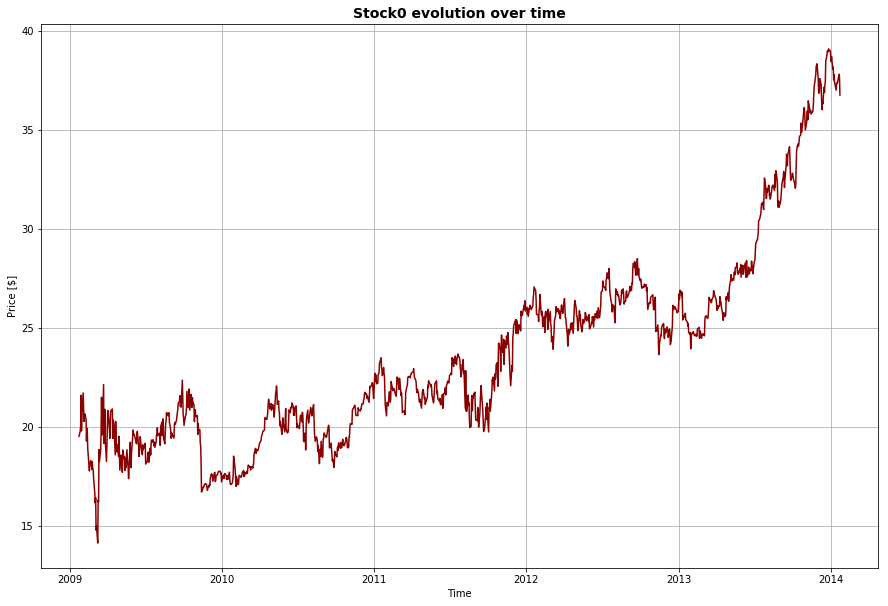

In [25]:
# STOCK 0 MOVEMENTS
plt.figure(figsize=(15,10))
dates, values = zip(*trimmedStock0)
plt.title("Stock0 evolution over time", weight="semibold", fontsize="14")
plt.xlabel("Time")
plt.ylabel("Price [$]")
plt.grid()
plt.plot(dates, values, color="darkred")

# SHOW
plt.show()

<div class="alert alert-success">
The value of the first stock is clearly increasing (even if very irregularly) over time.
</div>

### Dealing with missing values
We expect that we have the price of instruments and factors **in each business day**. Unfortunately, there are many missing values in our data: this means that we miss data for some days, e.g. we have data for the Monday of a certain week, but not for the subsequent Tuesday. So, we need a function that helps filling these missing values.

Next, we provide to you the function to fill missing value: read it carefully!

In [26]:
# FUNCTION TO FILL THE MISSING VALUES
def fillInHistory(history, start, end):
    
    curr = history
    filled = []
    idx = 0
    curDate = start
    numEntries = len(history)
    distorsion = 0
    while curDate < end:
        
        # if the next entry is in the same day
        # or the next entry is at the weekend
        # but the curDate has already skipped it and moved to the next monday
        # (only in that case, curr[idx + 1][0] < curDate )
        # then move to the next entry
        while idx + 1 < numEntries and curr[idx + 1][0] == curDate:
            idx +=1

        # only add the last value of instrument in a single day
        # check curDate is weekday or not
        # 0: Monday -> 5: Saturday, 6: Sunday
        if curDate.weekday() < 5:
            
            filled.append((curDate, curr[idx][1]))
            
            # we are moving a value from a date to another: add the difference to distorsion
            distorsion += abs((curr[idx][0] - curDate).days)
            
            # move to the next business day
            curDate += timedelta(days=1)
        
        # skip the weekends
        elif curDate.weekday() >= 5:
            # if curDate is Sat, skip 2 days, otherwise, skip 1 day
            curDate += timedelta(days=(7-curDate.weekday()))

    return filled, distorsion

<div class="alert alert-success">
**What does the function *fillInHistory* actually do?**<br>
Starting from the beginning of history we loop over the whole dataset: at each iteration first of all we are going to detect the first misaligned entry using another while loop; once found we check the current day and we move the misaligned line to that day if and only if it is a workday (adding it to 'filled', the new set to return). Otherwise we have to jump to the next Monday and repeat again what we have explained so far.
</div>

<div class="alert alert-success">
**What is the <u>distorsion</u> variable?**<br>
The fillInHistory function is really useful to fix problems in our dataset but at the same time we are actually changing real data. In many of cases we can affirm that it's a good approximation, it doesn't alter completely the history of a stock. Are we sure that we affirm this for ALL the stocks? We introduce the distorsion index that we increment each time we move one daily value from a date to another, adding the difference between the two last ones. If everything is ok in the history list the distorsion is zero. If there is no missing value but there is a skew between the start date we want and the real start date we simply add this difference for each value. Last but not least, if we have a lot of missing values probably we add large quantities because of the "holes" and the disorder index will be high. In order to get better about this fact, let's plot the distorsion for each stock we have.
</div>

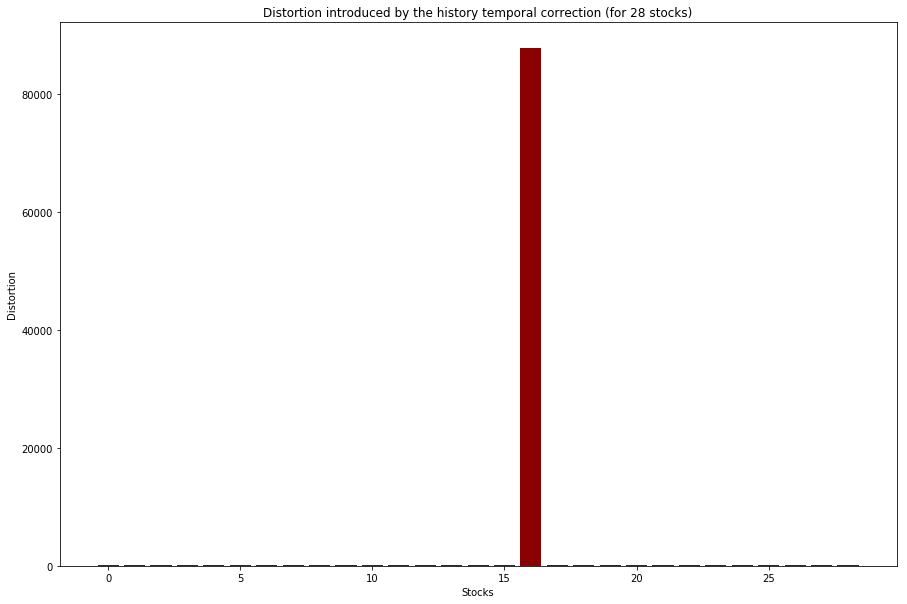

In [27]:
# DISTORTION CALCULATION
distorsions = [fillInHistory(trimToRegion(stock, start, end), start, end)[1] for stock in rawStocks]
    
# SHOW THE DISTORTION
plt.figure(figsize=(15,10))
plt.title("Distortion introduced by the history temporal correction (for 28 stocks)")
plt.xlabel("Stocks")
plt.ylabel("Distortion")
plt.bar(range(len(rawStocks)), distorsions, color="darkred")
plt.show()

<div class="alert alert-success">
We can notice that for stock #16 the fillInHistory function introduced a huge distorsion and it is not good at all! Probably we have a lot of missing values for it. For this reason we are going to filter out all the stocks for which we have a distorsion over a threshold. In our case we decided to set this threshold to 5 * len(history of the stock): supposing that we have no missing values we ignore the stock if we are moving the history one business-week back. If we have (a lot) missing values the distosion will be even higher and it will be discarded.
</div>

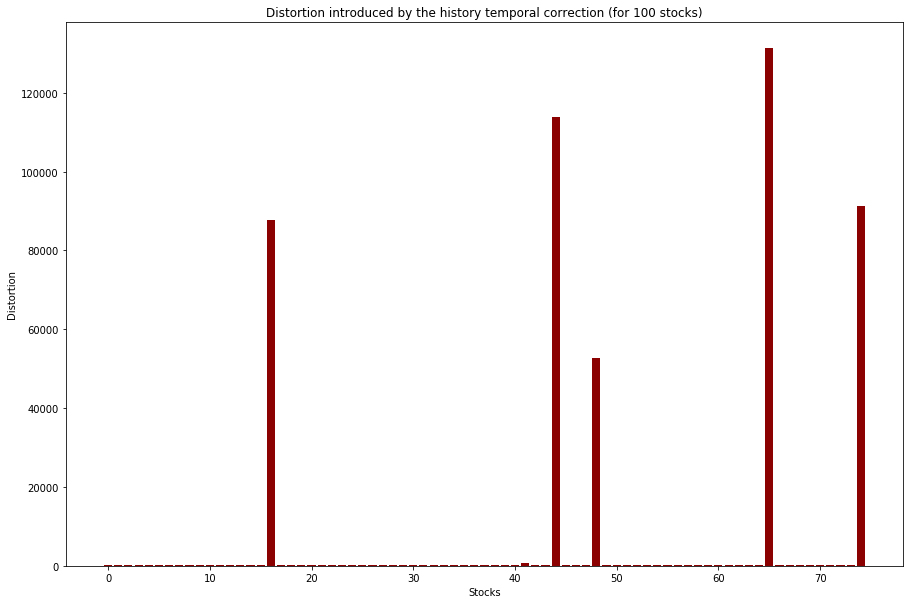

In [28]:
# LOAD MORE STOCKS
rawStocks100 = loadRawStocks(100)

# DISTORTION CALCULATION
distorsions = [fillInHistory(trimToRegion(stock, start, end), start, end)[1] for stock in rawStocks100]

# SHOW THE DISTORTION
plt.figure(figsize=(15,10))
plt.title("Distortion introduced by the history temporal correction (for 100 stocks)")
plt.xlabel("Stocks")
plt.ylabel("Distortion")
plt.bar(range(len(rawStocks100)), distorsions, color="darkred")
plt.show()

<div class="alert alert-success">
In the previous case we considered only 30 stocks and we noticed the problem only in one case. Showing the last graph we check that it is not a isolated case but a problem that can occur increasing the number of considered stocks.<br>
<br>
Now let's see what happens with our 4 factors:
</div>

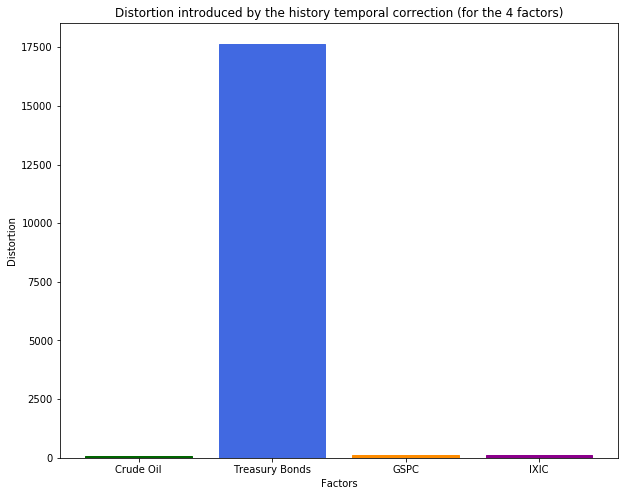

In [29]:
# DISTORTION CALCULATION FOR THE 4 FACTORS
distorsions = [fillInHistory(trimToRegion(factor, start, end), start, end)[1] for factor in (factors1 + factors2)]

# SHOW THE DISTORTION
plt.figure(figsize=(10,8))
plt.title("Distortion introduced by the history temporal correction (for the 4 factors)")
plt.xlabel("Factors")
plt.ylabel("Distortion")
plt.xticks(range(0,4), ["Crude Oil", "Treasury Bonds", "GSPC", "IXIC"])
barlist = plt.bar(range(0,4), distorsions, color="darkred")
barlist[0].set_color("darkgreen")
barlist[1].set_color("royalblue")
barlist[2].set_color("darkorange")
barlist[3].set_color("darkmagenta")
plt.show()

#### Question 4.5
<div class="alert alert-info">
Trim data of stocks and factors into the given time interval.
</div>

In [30]:
def loadStocks(rawStocks, allFactors, start, end):

    # TRIM TO A TIME REGION AND FILL THE MISSING VALUES
    stocks = [stock for stock, disorder in map(lambda stock: fillInHistory(trimToRegion(stock, start, end), start, end), 
                                     rawStocks) if disorder < 5*len(stock)]
    factors = [factor for factor, _ in map(lambda factor: fillInHistory(trimToRegion(factor, start, end), start, end), 
                                     allFactors)]
    
    return stocks, factors

In [31]:
# MERGE THE TWO FACTORS
allFactors = factors1 + factors2

# LOAD THE CLEAN STOCKS AND FACTORS
stocks, factors = loadStocks(rawStocks, allFactors, start, end)

# TEST OUR CODE
displaySideBySide(factors[0][:5], factors[0][-5:],
                  header=["Date", "Close price"],
                  title="First and last results for the Crude Oil factor")

displaySideBySide(stocks[0][:5], stocks[0][-5:],
                  header=["Date", "Close price"],
                  title="First and last results for the first stock")

Date,Close price
2009-01-23,46.47
2009-01-26,45.73
2009-01-27,41.58
2009-01-28,42.16
2009-01-29,41.44
Date,Close price
2014-01-16,93.96
2014-01-17,94.37
2014-01-20,93.93
2014-01-21,94.99


Date,Close price
2009-01-23,19.549999
2009-01-26,19.809999
2009-01-27,20.090000
2009-01-28,21.620001
2009-01-29,19.820000
Date,Close price
2014-01-16,37.400002
2014-01-17,37.380001
2014-01-20,37.380001
2014-01-21,37.820000


Recall that Value at Risk (VaR) deals with **losses over a particular time horizon**. We are not concerned with the absolute prices of instruments, but how those prices **change over** a given period of time. In our project, we will set that length to two weeks: we use the sliding window method to transform time series of prices into an overlapping sequence of price change over two-week intervals.

The figure below illustrates this process. The returns of market factors after each two-week interval is calculated in the very same way.

![](https://dl.dropboxusercontent.com/s/r9ucsicichb6gjh/two-week-time-interval.svg)

In [32]:
def buildWindow(seq, k=2):
    "Returns a sliding window (of width k) over data from iterable data structures"
    "   s -> (s0,s1,...s[k-1]), (s1,s2,...,sk), ...                   "
    it = iter(seq)
    result = tuple(islice(it, k))
    if len(result) == k:
        yield result  
    for elem in it:
        result = result[1:] + (elem,)
        yield result

#### Question 4.6
<div class="alert alert-info">
Compute the returns of the stocks after each two-week time window.
</div>

In [33]:
# FUNCTION TO CALCULATE THE RETURN FOR A TIME WINDOW
def calculateReturn(window):
    return window[-1][1] - window[0][1]

# FUNCTION TO LOOP OVER ALL THE WINDOWS, TO CALCULATE THE RETURN
# (the window is of two business weeks: 10 days)
def twoWeekReturns(history):
    return [calculateReturn(entry) for entry in buildWindow(history, 10)]

In [34]:
# GET THE RETURNS FOR STOCKS AND FACTORS
stocksReturns = list(map(twoWeekReturns, stocks))
factorsReturns = list(map(twoWeekReturns, factors))

# TEST OUR FUNCTIONS
displaySideBySide(stocksReturns[0][:5], stocksReturns[0][-5:],
                  header=["Return"],
                  title="First 5 and Last 5 return for Stock 0:")

Return
1.090000
0.870001
0.299999
-2.310002
0.139999
Return
-1.309997
-0.689999
-0.799999
0.279999


Alright! Now we have data that is properly aligned to start the training process: stocks' returns and factors' returns, per time windows of two weeks. Next, we will apply the MCS method.

## 5.5. Summary guidelines to apply the MCS method on the data we prepared
Next, we overview the steps that you have to follow to build a model of your data, and then use Monte Carlo simulations to produce output distributions:

- **Step 1**: Defining the relationship between the market factors and the instrument's returns. This relationship takes the form of a model fitted to historical data.
- **Step 2**: Defining the distributions for the market conditions (particularly, the returns of factors) that are straightforward to sample from. These distributions are fitted to historical data. 
- **Step 3**: Generate the data for each trial of a Monte Carlo run: this amount to generating the random values for market conditions along with these distributions.
- **Step 4**: For each trial, from the above values of market conditions, and using the relationship built in step 1, we calculate the return for each instrument and the total return. We use the returns to define an empirical distribution over losses. This means that, if we run 100 trials and want to estimate the 5% VaR, we would choose it as the loss from the trial with the fifth greatest loss.
- **Step 5**: Evaluating the result

## 5.6. Applying MCS

### Step 1: Defining relationship between market factors and instrument's returns

In our simulation, we will use a simple linear model. By our definition of return, a factor return is a **change** in the value of a market factor **over a particular time period**, e.g. if the value of the S&P 500 moves from 2000 to 2100 over a time interval, its return would be 100.

A vector that contains the return of 4 market factors is called a *market factor vector*. Generally, instead of using this vector as features, we derive a set of features from simple transformation of it. In particular, a vector of 4 values is transformed into a vector of length $m$ by function $F$. In the simplest case $F(v) = v$.

Denote $v_t$ the market factor vector, and $f_t$ the transformed features of $v_t$ at time $t$.

$f_{tj}$ is the value of feature $j$ in $f_t$.

Denote $r_{it}$ the return of instrument $i$ at time $t$ and $c_i$ the [intercept term](http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-to-interpret-the-constant-y-intercept) of instrument $i$.

We will use a simple linear function to calculate $r_{it}$ from $f_t$:

$$
r_{it} = c_i + \sum_{j=1}^{m}{w_{ij}*f_{tj}}
$$

where $w_{ij}$ is the weight of feature $j$ for instrument $i$.

All that above means that given a market factor vector, we have to apply featurization and then use the result as a surrogate for calculating the return of the instruments, using the above linear function.

There are two questions that we should consider: **how we apply featurization to a factor vector?** and **how to pick values for $w_{ij}$?**

**How we apply featurization to a factor vector?**
In fact, the instruments' returns may be non-linear functions of the factor returns. So, we should not use factor returns as features in the above linear function. Instead, we transform them into a set of features with different size. In this Notebook, we can include some additional features in our model that we derive from non-linear transformations of the factor returns. We will try adding two more features for each factor return: its square and its square root values. So, we can still assume that our model is a linear model in the sense that the response variable is a linear function of the new features. *Note that the particular feature transformation described here is meant to be an illustrative example of some of the options that are available: it shouldn't be considered as the state of the art in predictive financial modeling!!*.

**How to pick values for $w_{ij}$?**

For all the market factor vectors in our historical data, we transform them to feature vectors. Now, we have feature vectors in many two-week intervals and the corresponding instrument's returns in these intervals. We can use Ordinary Least Square (OLS) regression model to estimate the weights for each instrument such that our linear function can fit to the data. The parameters for OLS function are:

- `x`: The collection of columns where **each column** is the value of **a feature** in many two-week interval
- `y`: The return of an instrument in the corresponding time interval of x.

The figure below shows the basic idea of the process to build a statistical model for predicting the returns of stock X.

![](https://dl.dropboxusercontent.com/s/kbjtwmnr4w31uev/process-build-model3.svg)


### Question 5
#### Question 5.1

<div class="alert alert-info">
Currently, our data is in form of:  

$$
factorsReturns=
\begin{bmatrix}
 r_{00} & r_{01} & r_{02} & ... & r_{0k} \\
 r_{10} & r_{11} & r_{12} & ... & r_{1k} \\
 ... & ... & ... & ... & ... \\
 r_{n0} & r_{n1} & r_{n2} & ... & r_{nk}\\
\end{bmatrix}
$$

<ul></ul>

$$
stocksReturns=
\begin{bmatrix}
 s_{00} & s_{01} & s_{02} & ... & s_{0k} \\
 s_{10} & s_{11} & s_{12} & ... & s_{1k} \\
 ... & ... & ... & ... & ... \\
 s_{n0} & s_{n1} & s_{n2} & ... & s_{nk}\\
\end{bmatrix}
$$

<ul></ul>

Where, $r_{ij}$ is the return of factor $i^{th}$ in time window $j^{th}$, $k$ is the number of time windows, and $n$ is the number of factors. A similar definition goes for $s_{ij}$.

<ul></ul>

In order to use OLS, the parameter must be in form of:

<ul></ul>

$$
x=factorsReturns^T =
\begin{bmatrix}
 r_{00} & r_{10} & ... & r_{n0} \\
 r_{01} & r_{11} & ... & r_{n1} \\
 r_{02} & r_{12} & ... & r_{n2}\\
 ... & ... & ... & ... \\
 r_{0k} & r_{1k} & ... & r_{nk}\\
\end{bmatrix}
$$

<ul></ul>

Whereas, $y$ can be any row in `stocksReturns`.

<ul></ul>

So, we need a function to transpose a matrix. Write a function named `transpose` to do just that.
</div>

In [35]:
# FUNCTION TO TRANSPOSE A MATRIX
def transpose(matrix):
    return list(map(list, zip(*matrix)))

# TEST THE TRANSPOSE FUNCTION
assert (transpose([[1,2,3], [4,5,6], [7,8,9]]) == [[1, 4, 7], [2, 5, 8], [3, 6, 9]]), "Function transpose runs incorrectly"

#### Question 5.2
<div class="alert alert-info">
Write a function named `featurize` that takes a list factor's returns $[x_1, x_2,...,x_k]$ and transform it into a new list of features $[u_1,u_2,..,u_k, v_1, v_2,..,v_k, x_1,x_2,...,x_k]$.

<ul></ul>

Where,  


$u_i$ = $\left\{
	\begin{array}{ll}
		x_i^2 & \mbox{if } x_i \geq 0 \\
		-x_i^2 & \mbox{if } x_i < 0
	\end{array}
\right.
$

<ul></ul>

and  

$v_i$ = $\left\{
	\begin{array}{ll}
		\sqrt{x_i} & \mbox{if } x_i \geq 0 \\
		-\sqrt{x_i} & \mbox{if } x_i < 0
	\end{array}
\right.
$  

</div>

In [36]:
# FUNCTION TO EXPAND (FEATURIZE) THE FACTOR
def featurize(factorReturns):
    squaredReturns = [np.sign(value) * (value)**2 for value in factorReturns]
    squareRootedReturns = [np.sign(value) * abs(value)**0.5 for value in factorReturns]
    return squaredReturns + squareRootedReturns + factorReturns

# TEST THE FUNCTION
assert (featurize([4, -9, 25]) == [16, -81, 625, 2, -3, 5, 4, -9, 25]), "Function runs incorrectly"

#### Question 5.3
<div class="alert alert-info">
Using OLS, estimate the weights for each feature on each stock. What is the shape of `weights` (size of each dimension)?  

Explain it.
</div>

In [37]:
# FUNCTION TO BUILD THE MODEL (WEIGHTS) STARTING FROM FACTORS AND STOCKS RETURNS
def buildModel(factorsReturns, stocksReturns):
    
    def estimateParams(y, x):
        return sm.OLS(y, x).fit().params

    # TRANSPOSE THE 'FACTORS RETURNS' MATRIX
    factorMat = transpose(factorsReturns)

    # FEATURIZE IT
    factorFeatures = list(map(featurize, factorMat))

    # TRANSFORM IN NUMPY ARRAY AND ADD THE INTERCEPT
    factorColumns = sm.add_constant(np.array(factorFeatures), prepend=True)

    # ESTIMATE THE WEIGHTS
    weights = [estimateParams(sr, factorColumns) for sr in stocksReturns]
    
    return weights

In [38]:
# BUILD THE MODEL
weights = buildModel(factorsReturns, stocksReturns)

# PRINT THE WEIGHTS
displayTable(weights, ["w(" + str(i) + ")" for i in range(0,13)], "The weights are:")

The weights are:


w(0),w(1),w(2),w(3),w(4),w(5),w(6),w(7),w(8),w(9),w(10),w(11),w(12)
0.003209,-0.002455,-6.258536,0.000202,-4.278916e-05,0.036810,-1.036710,0.026931,-0.062658,0.000003,3.638331,0.003389,0.011121
-0.089474,0.002449,-2.432990,0.000291,-5.422231e-05,0.191384,0.704395,0.110048,-0.048395,-0.100717,0.750872,-0.038184,0.031269
-0.014365,0.002469,-1.943656,0.000056,-1.277379e-05,0.038611,-0.205334,0.001903,-0.002248,-0.048091,0.970524,-0.001500,0.002527
0.046389,-0.000342,-1.527536,0.000007,-3.123108e-06,0.013150,0.128905,0.058604,-0.057415,0.003653,-0.352701,-0.007955,0.009391
-0.187102,0.007770,2.742755,0.000397,-6.999665e-05,-0.008197,0.488819,0.281979,-0.082592,-0.082633,0.796296,-0.067639,0.026696
0.025666,-0.001778,0.931331,0.000032,-4.689374e-06,-0.069639,-0.062646,0.030119,0.001374,0.038508,-0.168047,-0.004693,-0.000057
0.052289,0.006016,-0.007887,-0.000226,3.346846e-05,0.361797,-0.181780,-0.035371,0.009001,-0.198783,-0.038005,0.022523,-0.001532
-0.006943,0.004915,0.890764,0.000014,-1.768643e-05,0.070518,-0.618628,0.031206,0.008568,-0.072665,1.418555,-0.004299,0.003416
-0.046481,0.003644,0.859669,0.000128,-2.322949e-05,0.024345,-0.102435,0.008089,-0.001714,-0.035346,-0.022097,-0.007132,0.004650
-0.020865,0.012170,10.135562,0.000341,-2.961303e-05,0.561374,1.521963,-0.105232,0.135271,-0.335935,-7.908923,0.028590,-0.005737


<div class="alert alert-success">
The weights found are obviously of a shape which is strongly related to the factors matrix. Indeed, we can find for each row 13 weights that correspond to the 12 factors (after expansion) and the intercept term that has been added.<br>
The height of the weights matrix (so the number of rows) is instead referred to the number of time windows that we are considering in our model construction.
</div>

### Step 2: Defining the distributions for the market conditions
Since we cannot define the distributions for the market factors directly, we can only approximate their distribution.
The best way to do that, is plotting their value. However, these values may fluctuate quite a lot. 

Next, we show how to use the Kernel density estimation (KDE) technique to approximate such distributions. In brief, kernel density estimation is a way of smoothing out a histogram: this is achieved by assigning (or centering) a probability distribution (usually a normal distribution) to each data point, and then summing. So, a set of two-week-return samples would result in a large number of "super-imposed" normal distributions, each with a different mean. 

To estimate the probability density at a given point, KDE evaluates the PDFs of all the normal distributions at that point and takes their average. The smoothness of a kernel density plot depends on its *bandwidth*, and the standard deviation of each of the normal distributions. For a brief introduction on KDE, please refer to this [link](https://en.wikipedia.org/wiki/Kernel_density_estimation).

In [39]:
def plotDistribution(samples, r, c, i, title, color, others=None):
    
    def getDomainAndDensity(samples):
        
        # OBTAIN PARAMETERS FROM SAMPLES
        vmin = min(samples)
        vmax = max(samples)
        stddev = np.std(samples)

        # CALCULATE DOMAIN
        domain = np.arange(vmin, vmax, (vmax-vmin)/100)
        
        # CALCULATE BANDWIDTH
        bandwidth = 1.06 * stddev * pow(len(samples), -.2)

        # CALCULATE DENSITY
        kde = KDEUnivariate(samples)
        kde.fit(bw=bandwidth)
        density = kde.evaluate(domain)
        
        return domain, density
    
    
    # GET DOMAIN AND DENSITY
    domain, density = getDomainAndDensity(samples)
    if (others is not None):
        domain2, density2 = getDomainAndDensity(others)
    
    # PLOT
    plt.subplot(r, c, i)
    plt.plot(domain, density, color=color)
    
    # IF THERE'S A SECOND PLOT TO COMPARE WITH, PLOT IT
    if (others is not None):
        line, = plt.plot(domain2, density2, color="grey", linestyle="--", label="Real data")
        plt.legend(handles=[line])
    
    plt.grid()
    plt.title(title, fontsize="12", weight="semibold")

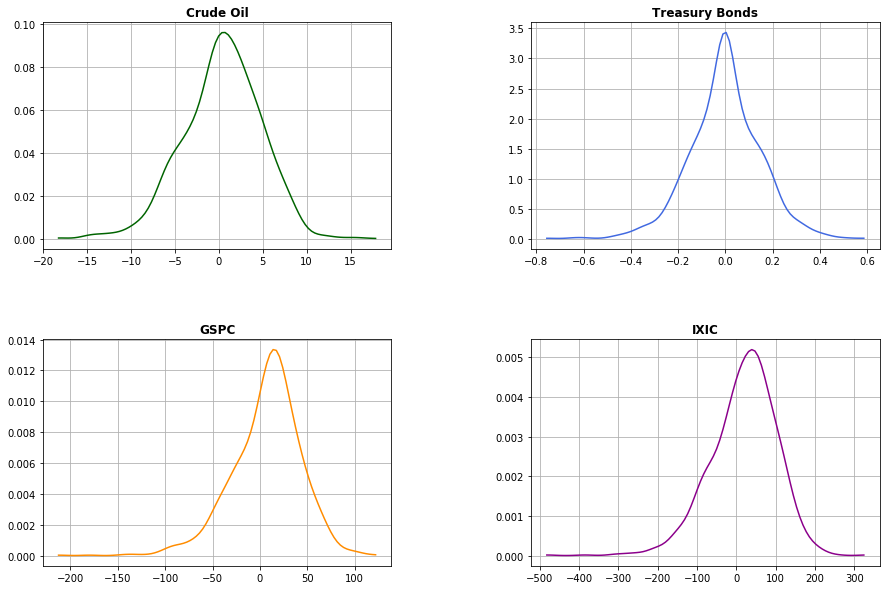

In [40]:
# PLOT THE DISTRIBUTIONS OF ALL THE 4 FACTOR RETURNS
plt.figure(figsize=(15,10))
plotDistribution(factorsReturns[0], 2, 2, 1, "Crude Oil", "darkgreen")
plotDistribution(factorsReturns[1], 2, 2, 2, "Treasury Bonds", "royalblue")
plotDistribution(factorsReturns[2], 2, 2, 3, "GSPC", "darkorange")
plotDistribution(factorsReturns[3], 2, 2, 4, "IXIC", "darkmagenta")
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

For the sake of simplicity, we can say that our smoothed versions of the returns of each factor can be represented quite well by a normal distribution. Of course, more exotic distributions, perhaps with fatter tails, could fit more closely the data, but it is outside the scope of this Notebook to proceed in this way.

Now, the simplest way to sample factors returns is to use a normal distribution for each of the factors, and sample from these distributions independently. However, this approach ignores the fact that market factors are often correlated. For example, when the price of crude oil is down, the price of treasury bonds is down too. We can check our data to verify about the correlation.

### Question 6

#### Question 6.1
<div class="alert alert-info">

Calculate the correlation between market factors and explain the result.
<br><br>
<div class="label label-success">HINT</div> function `np.corrcoef` might be useful.
</div>

Correlation matrix of Factors Returns:


,,,
1.000000,0.387885,0.474116,0.458412
0.387885,1.000000,0.584477,0.583064
0.474116,0.584477,1.000000,0.952276
0.458412,0.583064,0.952276,1.000000


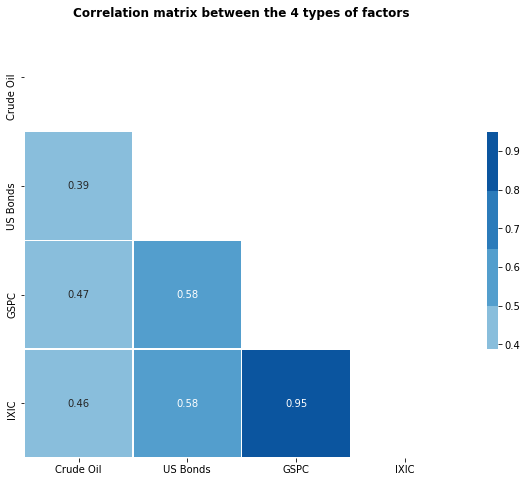

In [41]:
# BUILD CORRELATION MATRIX
correlation = np.corrcoef(factorsReturns)

# PRINT CORRELATION MATRIX
displayTable(correlation, ["" for i in range(0,4)], "Correlation matrix of Factors Returns:")

# HEATMAP
# Generate a mask for the upper triangle
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))
plt.title("Correlation matrix between the 4 types of factors", fontsize="12", weight="semibold")
cmap = sns.color_palette("Blues")

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=0.95, center=0.5,
           square=True, linewidths=.5, cbar_kws={"shrink": .5},
           xticklabels=["Crude Oil", "US Bonds", "GSPC", "IXIC"],
           yticklabels=["Crude Oil", "US Bonds", "GSPC", "IXIC"], annot=True)
plt.show()

<div class="alert alert-success">
From the correlation matrix we can see that there are some factors which are highly correlated between each other. For example. we can see that the 4th factor is strongly connected to the 3rd one. There is also a medium correlation (about 58%) between the 2nd-3rd and 2nd-4th.
A very low correlation instead, can be found between the first two factors.<br><br>
Now we are going to investigate about the really high correlation between GSPC and IXIC.
</div>

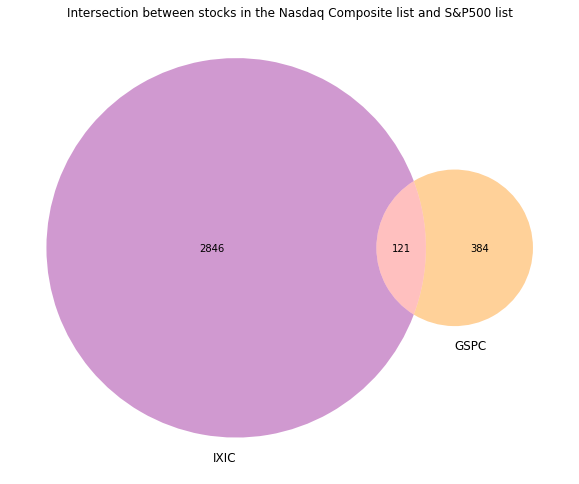

In [42]:
# LOAD THE STOCKS CONTAINED IN THE GSPC AND IXIC FACTORS
nasdaqCompositeCompanies = pd.read_csv(baseFolder + "/nasdaq-list.csv")
sp500Companies = pd.read_csv(baseFolder + "/s&p-list.csv")

# VENN DIAGRAM
plt.figure(figsize=(10,10))
venn2([set(nasdaqCompositeCompanies["Symbol"]),
       set(sp500Companies["Symbol"])],
       set_labels=("IXIC","GSPC"),
       set_colors=("darkmagenta", "darkorange"))
plt.title('Intersection between stocks in the Nasdaq Composite list and S&P500 list')
plt.show()

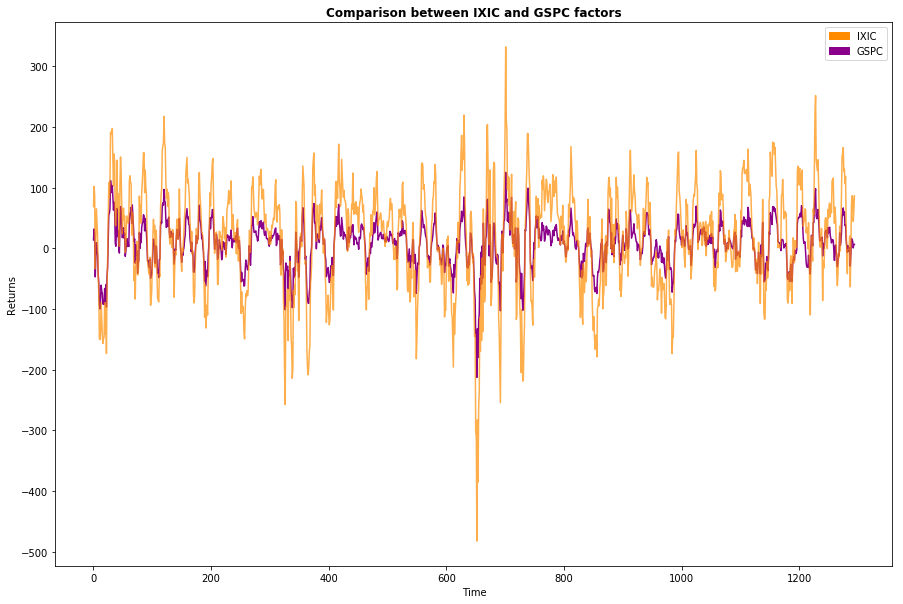

In [43]:
# PLOT OF IXIC AND GSPC FACTORS
plt.figure(figsize=(15,10))

# GSPC
plt.plot(factorsReturns[2], color="darkmagenta")

# IXIC
plt.plot(factorsReturns[3], color="darkorange", alpha=0.7)

# SHOW
plt.xlabel("Time")
plt.ylabel("Returns")
magenta_patch = mpatches.Patch(color='darkmagenta', label='GSPC')
orange_patch = mpatches.Patch(color='darkorange', label='IXIC')
plt.legend(handles=[orange_patch, magenta_patch])
plt.title("Comparison between IXIC and GSPC factors", fontsize="12", weight="semibold")
plt.show()

<div class="alert alert-success">
The Venn diagram shows us that more than 20% of companies in the S&P500 list (GSPC) are in the Nasdaq stock market. That's because Standard & Poor's 500 is a stock market that actually contains of 500 large companies listed in the NYSE or Nasdaq. In addition we can notice from the second graph that both follow the same behaviour (look at peak and drops in time). These plots explain why we get an high correlation between these two factors.
<br>
<br>
The "not-so-low" correlation between other factors is quiet normal, all the trends in the stock market (and not only, think about war, crisis, speculation, instable conditions in the Middle East which affect the crude oil prices...) influence each other in some way.
</div>

The multivariate normal distribution can help here by taking the correlation information between the factors into account. Each sample from a multivariate normal distribution can be thought of as a vector. Given values for all of the dimensions but one, the distribution of values along that dimension is normal. But, in their joint distribution, the variables are not independent.

For this use case, we can write:

$$
\left(\begin{array}{c}f_{1}\\f_{2}\\f_{3}\\f_{4} \end{array}\right)
\sim N 
\left[
  \left(
    \begin{array}{c}
      \mu_1\\ \mu_2 \\ \mu_3 \\ \mu_4 
    \end{array}
  \right), 
  \left(
    \begin{array}{cccc}
      \sigma^2_1 & \rho_{12} \sigma_1\sigma_2 & \rho_{13} \sigma_1\sigma_3 & \rho_{14} \sigma_1\sigma_4 \\ 
      \rho_{12}\sigma_2\sigma_1 & \sigma^2_2 & \rho_{23} \sigma_2\sigma_3 & \rho_{24} \sigma_2\sigma_4\\
      \rho_{13} \sigma_3\sigma_1 & \rho_{23} \sigma_3\sigma_2 & \sigma^2_3 & \rho_{34} \sigma_3\sigma_4 \\ 
      \rho_{14} \sigma_4\sigma_1 & \rho_{24} \sigma_4\sigma_2 & \rho_{34} \sigma_3\sigma_4 & \sigma_4^2 \\ 
    \end{array}
  \right)
\right]
$$

Or,

$$
f_t \sim N(\mu, \sum)
$$

Where $f_1$, $f_2$, $f_3$ and $f_4$ are the market factors, $\sigma_i$ is the standard deviation of factor $i$, $\mu$ is a vector of the empirical means of the returns of the factors and $\sum$ is the empirical covariance matrix of the returns of the factors.

The multivariate normal is parameterized with a mean along each dimension and a matrix describing the covariance between each pair of dimensions. When the covariance matrix is diagonal, the multivariate normal reduces to sampling along each dimension independently, but placing non-zero values in the off-diagonals helps capture the relationships between variables. Whenever having the mean of this multivariate normal distribution and its covariance matrix, we can generate the sample values for market factors.

Next, we will calculate the mean and the covariance matrix of this multivariate normal distribution from the historical data.


#### Question 6.2
<div class="alert alert-info">

Calculate the covariance matrix $\sum$ and the means $\mu$ of factors' returns then generate a random vector of factors return that follows a multivariate normal distribution $\sim N(\mu, \sum)$

<br><br>

<div class="label label-success">HINT</div>
Function `np.cov` can help calculating covariance matrix. Function `np.random.multivariate_normal(<mean>, <cov>)` is often used for generating samples.

</div>

In [44]:
# BUILD COVARIANCE MATRIX
factorCov = np.cov(factorsReturns)

# BUILD MEAN
factorMeans = [sum(fr)/len(fr) for fr in factorsReturns]

# BUILD SAMPLES FROM DISTRIBUTION
sample = np.random.multivariate_normal(factorMeans, factorCov)

# SHOW COVARIANCE MATRIX, MEAN AND SAMPLES
displayTable(factorCov, ["" for i in range(0,4)], "Factors covariance matrix:")
displayTable(np.matrix(factorMeans), ["" for i in range(0,4)], "Factors means:")
displayTable(np.matrix(sample), ["" for i in range(0,4)], "Factors samples:")

Factors covariance matrix:


,,,
20.371231,0.263084,77.728150,172.733934
0.263084,0.022582,3.190316,7.314943
77.728150,3.190316,1319.380308,2887.758819
172.733934,7.314943,2887.758819,6969.894435



Factors means:


,,,
0.359089,-0.001314,6.953869,18.709227



Factors samples:


,,,
-0.675586,-0.093981,30.776908,17.019008


## Step 3&4: Generating samples, running simulation and calculating the VaR

We define some functions that helps us calculating VaR 5%. You will see that the functions below are pretty complicated! This is why we provide a solution for you: however, study them well!!

The basic idea of calculating VaR 5% is that we need to find a value such that only 5% of the losses are bigger than it. That means the 5th percentile of the losses should be VaR 5%.

VaR can sometimes be problematic though, since it does give any information on the extent of the losses which can exceed the VaR estimate. CVar is an extension of VaR that is introduced to deal with this problem. Indeed, CVaR measures the expected value of the loss in those cases where VaR estimate has been exceeded.

In [45]:
def fivePercentVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return topLosses[-1]

# an extension of VaR
def fivePercentCVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return sum(topLosses)/len(topLosses)

def bootstrappedConfidenceInterval(
      trials, computeStatisticFunction,
      numResamples, pValue):
    stats = []
    for i in range(0, numResamples):
        resample = trials.sample(True, 1.0)
        stats.append(computeStatisticFunction(resample))
    sorted(stats)
    lowerIndex = int(numResamples * pValue / 2 - 1)
    upperIndex = int(np.ceil(numResamples * (1 - pValue / 2)))
    return (stats[lowerIndex], stats[upperIndex])

Next, we will run the Monte Carlo simulation 10,000 times, in parallel using Spark. Remember to set the parallelism value accordingly.

### Question 7
<div class="alert alert-info">
Complete the code below to define the simulation process and calculate VaR 5%.
</div>

<div class="alert alert-success">
First of all, let's check if the Multivariate Normal can be a good statistical distribution for our data.<br>
</div>

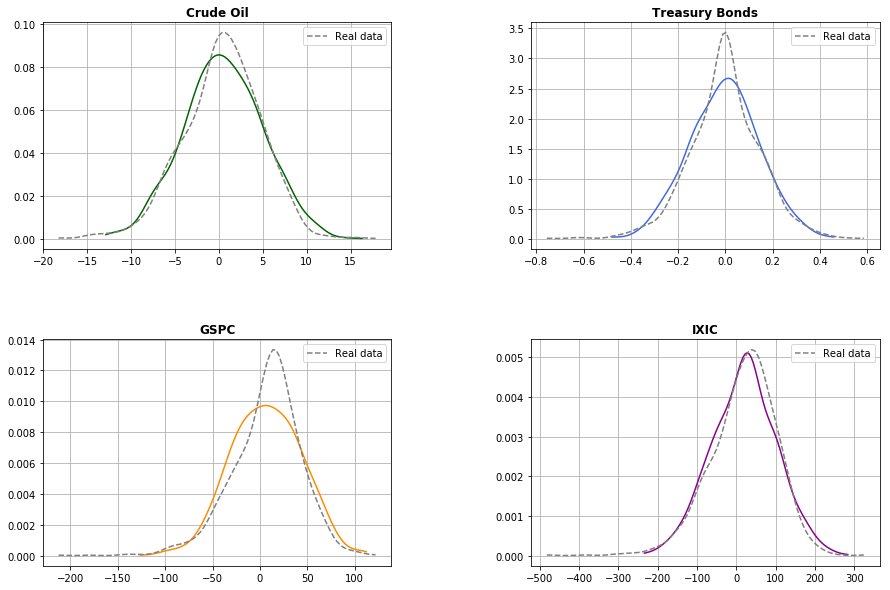

In [46]:
# GENERATE SAMPLES USING THE MULTIVARIATE NORMAL
samples = [[],[],[],[]]
for i in range(0, 1295):
    samples[0].append(np.random.multivariate_normal(factorMeans, factorCov)[0])
    samples[1].append(np.random.multivariate_normal(factorMeans, factorCov)[1])
    samples[2].append(np.random.multivariate_normal(factorMeans, factorCov)[2])
    samples[3].append(np.random.multivariate_normal(factorMeans, factorCov)[3])
    
# SHOW THE RESULTS AND COMPARE WITH REAL DATA
plt.figure(figsize=(15,10))
plotDistribution(samples[0], 2, 2, 1, "Crude Oil", "darkgreen", factorsReturns[0])
plotDistribution(samples[1], 2, 2, 2, "Treasury Bonds", "royalblue", factorsReturns[1])
plotDistribution(samples[2], 2, 2, 3, "GSPC", "darkorange", factorsReturns[2])
plotDistribution(samples[3], 2, 2, 4, "IXIC", "darkmagenta", factorsReturns[3])
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

<div class="alert alert-success">
As we can see, the multivariate normal (of course) represents an heavy approximation of our real factors. However, it makes sense to build a model using this distribution! The shape, even if is not perfect, fits decently our data. Later in the notebook, we will try other distributions.<br>
<br>
Now we can build our model:
</div>

In [47]:
# RUN MONTE CARLO SIMULATION
def simulateTrialReturns(numTrials, factorMeans, factorCov, weights, distribution="normal"):
    
    trialReturns = []
    
    for i in range(0, numTrials):
        
        # GENERATE SAMPLES OF THE BUILT MODEL
        trialFactorReturns = np.random.multivariate_normal(factorMeans, factorCov)
        if distribution == "lognormal":
            trialFactorReturns = np.exp(trialFactorReturns)
            
        # FEATURIZE THE FACTOR RETURNS
        trialFeatures = featurize(trialFactorReturns.tolist())

        # INSERT INTERCEPT
        trialFeatures.insert(0, 1)

        # CALCULATE THE TOTAL RETURN
        trialTotalReturn = 0
        for w in weights.value:
            trialTotalReturn += np.array(w).dot(trialFeatures) # for each stock
        trialReturns.append(trialTotalReturn)
        
    return trialReturns

In [48]:
# SET PARAMETERS
parallelism = 4
numTrials = 10000
trialIndexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trialIndexes, parallelism)
bFactorWeights = sc.broadcast(weights)

# DISTRIBUTED COMPUTING OF SIMULATION
trials = seedRDD.flatMap(lambda idx: simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans,
                    factorCov,
                    bFactorWeights
                ))
trials.cache()

# CALCULATE VALUE AT RISK
valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

# SHOW VaR
displayTable(np.matrix(valueAtRisk), ["Value at Risk (VaR) 5%"], "")
displayTable(np.matrix(conditionalValueAtRisk), ["Conditional Value at Risk (CVaR) 5%"], "")

Value at Risk (VaR) 5%
-20.278447


Conditional Value at Risk (CVaR) 5%
-26.510572


The value of VaR depends on how many invested stocks and the chosen distribution of random variables. Assume that we get VaR 5% = -2.66,  that means that there is a 0.05 probability that the portfolio will fall in value by more than \$2.66 over a two weeks' period if there is no trading. In other words, the loses are less than \$2.66 over two weeks' period with 95% confidence level. When a loss over two weeks is more than \$2.66, we call it **failure** (or **exception**). Informally, because of 5% probability, we expect that there are only $0.05*W$ failures out of total $W$ windows.

### Step 5: Evaluating the results using backtesting method
In general, the error in a Monte Carlo simulation should be proportional to 1/sqrt(n), where n is the number of trials. This means, for example, that quadrupling the number of trials should approximately cut the error in half. A good way to check the quality of a result is backtesting on historical data. Backtesting is a statistical procedure where actual losses are compared to the estimated VaR. For instance, if the confidence level used to calculate VaR is 95% (or VaR 5%), we expect only 5 failures over 100 two-week time windows.

The most common test of a VaR model is counting the number of VaR failures, i.e., in how many windows, the losses exceed VaR estimate. If the number of exceptions is less than selected confidence level would indicate, the VaR model overestimates the risk. On the contrary, if there are too many exceptions, the risk is underestimated. However, it's very hard to observe the amount of failures suggested by the confidence level exactly. Therefore, people try to study whether the number of failures is reasonable or not, or will the model be accepted or rejected.

One common test is Kupiec's proportion-of-failures (POF) test. This test considers how the portfolio performed at many historical time intervals and counts the number of times that the losses exceeded the VaR. The null hypothesis is that the VaR is reasonable, and a sufficiently extreme test statistic means that the VaR estimate does not accurately describe the data. The test statistic is computed as:

$$
-2ln\Bigg(\frac{(1-p)^{T-x}p^x}{(1-\frac{x}{T})^{T-x}(\frac{x}{T})^x}\Bigg)
$$

where:

$p$ is the quantile-of-loss of the VaR calculation (e.g., in VaR 5%, p=0.05),

$x$ (the number of failures) is the number of historical intervals over which the losses exceeded the VaR 

$T$ is  the total number of historical intervals considered

Or we can expand out the log for better numerical stability:

$$
\begin{equation}
-2\Big((T-x)ln(1-p)+x*ln(p)-(T-x)ln(1-\frac{x}{T})-x*ln(\frac{x}{T})\Big)
\end{equation}
$$

If we assume the null hypothesis that the VaR is reasonable, then this test statistic is drawn from a chi-squared distribution with a single degree of freedom. By using Chi-squared distribution, we can find the `p-value` accompanying our test statistic value.  If `p-value` exceeds the critical value of the Chi-squared distribution, we do have sufficient evidence to reject the null hypothesis that the model is reasonable. Or we can say, in that case, the model is considered as inaccurate.

For example, assume that we calculate VaR 5% (the confidence level of the VaR model is 95%) and get value VaR = 2.26. We also observed 50 exceptions over 500 time windows. Using the formula above, the test statistic `p-value` is calculated and equal to `8.08`. Compared to `3.84`, the critical value of Chi-squared distribution with one degree of freedom at probability 5%, the test statistic is larger. So, the model is rejected. The critical values of Chi-squared can be found by following [this link](https://people.richland.edu/james/lecture/m170/tbl-chi.html).
However, in this Notebook, it's not a good idea to find the corresponding critical value by looking in a "messy" table, especially when we need to change the confidence level. Instead, from `p-value`, we will calculate the probability of the test statistic in Chi-square thanks to some functions in package `scipy`. If the calculated probability is smaller than the quantile of loss (e.g, 0.05), the model is rejected and vice versa.


### Question 8

#### Question 8.1
<div class="alert alert-info">

Write a function to calculate the number of failures, that is when the losses (in the original data) exceed the VaR.<br>
<br>
<div class="label label-success">HINT</div>
<ul>
  <li>First, we need to calculate the total loss in each 2-week time interval</li>
  <li>If the total loss of a time interval exceeds VaR, then we say that our VaR fails to estimate the risk in that time interval</li>
  <li>Return the number of failures</li>
</ul>  

<div class="label label-danger">NOTE</div>
The loss is often having negative value, so, be careful when compare it to VaR.
</div>

In [49]:
def countFailures(stocksReturn, valueAtRisk):
    
    failures = 0
    numWindows = len(stocksReturn[0])
    
    # iterate over time intervals
    for i in range(0, numWindows):
        
        # calculate the losses in each time interval
        loss = sum([sr[i] for sr in stocksReturn])

        # if the loss exceeds VaR
        # Note that the "<" is enough for all the VaR range of values! (Explained below)
        if loss < valueAtRisk:
            failures += 1
            
    return failures

<div class="alert alert-success">
Note about the *if* construct which checks if the loss exceed the VaR:<br>
- if the loss is negative (a real loss) it exceeds the VaR if it's more negative than it (checked with "<").<br>
- if the loss is positive (not a loss), it is worse than the VaR if it's smaller than it (checked with "<").<br>
So, in any case, the check with the *"smaller-than" operator (<)* is enough.
</div>

#### Question 8.2
<div class="alert alert-info">

Write a function named `kupiecTestStatistic` to calculate the test statistic which was described in the above equation.

</div>

In [50]:
# FUNCTION FOR KUPIEC TEST
def kupiecTestStatistic(total, failures, confidenceLevel):
    failureRatio = failures / total
    logNumer = (total-failures) * np.log(1-confidenceLevel) + failures * np.log(confidenceLevel)
    logDenom = (total-failures) * np.log(1-failureRatio) + failures * np.log(failureRatio)
    return -2 * (logNumer - logDenom)

# TEST THE FUNCTION
assert (round(kupiecTestStatistic(250, 36, 0.1), 2) == 4.80), "function kupiecTestStatistic runs incorrectly"

Now we can find the p-value accompanying our test statistic value.

In [51]:
def kupiecTestPValue(stocksReturns, valueAtRisk, confidenceLevel):
    failures = countFailures(stocksReturns, valueAtRisk)
    N = len(stocksReturns)
    print("Number of failures:", failures)
    total = len(stocksReturns[0])
    testStatistic = kupiecTestStatistic(total, failures, confidenceLevel)
    # return 1 - stats.chi2.cdf(testStatistic, 1.0)
    return stats.chi2.sf(testStatistic, 1.0)

In [52]:
# GET VaR AND CVaR
varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)

# SHOW VALUES
displayTable(np.matrix(varConfidenceInterval), ["min", "max"], "VaR confidence interval:")
displayTable(np.matrix(cvarConfidenceInterval), ["min", "max"], "CVaR confidence interval:")
displayTable(np.matrix(kupiecTestPValue(stocksReturns, valueAtRisk, 0.05)), ["Kupiec test p-value"], "")

VaR confidence interval:


min,max
-20.437945,-20.56239



CVaR confidence interval:


min,max
-26.839049,-26.634942



Number of failures: 108



Kupiec test p-value
4.324810e-07


#### Question 8.3
<div class="alert alert-info">

Discuss the results you have obtained

</div>

<div class="alert alert-success">

PUT YOUR ANSWER HERE !

</div>

### Question 9
<div class="alert alert-info">
Assume that we invest in more than 100 stocks. Use the same market factors as for the previous questions to estimate VaR by running MCS, then validate your result.  

What is the main observation you have, once you answer this question? When you plan to invest in more instruments, how is your ability to predict the risk going to be affected?
</div>


In [53]:
## PREPROCESSING PHASE

# LOAD RAW DATA
rawStocks = loadRawStocks(100)
# allFactors is already loaded

# LOAD PROCESSED DATA
stocks, factors = loadStocks(rawStocks, allFactors, start, end)

# CALCULATE RETURNS
stocksReturns = list(map(twoWeekReturns, stocks))
factorsReturns = list(map(twoWeekReturns, factors))

In [54]:
## PARAMETERS ESTIMATION PHASE

# MODEL BUILDING
weights = buildModel(factorsReturns, stocksReturns)

# GET MULTIVARIATE
factorCov = np.cov(factorsReturns)
factorMeans = [sum(fr)/len(fr) for fr in factorsReturns]
sample = np.random.multivariate_normal(factorMeans, factorCov)

# SET PARAMETERS
parallelism = 4
numTrials = 10000
trialIndexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trialIndexes, parallelism)
bFactorWeights = sc.broadcast(weights)

# RUN
trials = seedRDD.flatMap(lambda idx: simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans,
                    factorCov,
                    bFactorWeights,
                ))
trials.cache()

# CALCULATE VaR
valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

# SHOW RESULTS
displayTable(np.matrix(valueAtRisk), ["Value at Risk (VaR) 5%"], "")
displayTable(np.matrix(conditionalValueAtRisk), ["Conditional Value at Risk (CVaR) 5%"], "")

Value at Risk (VaR) 5%
-537.831938


Conditional Value at Risk (CVaR) 5%
-898.511281


In [55]:
## BACKTESTING PHASE

# GET VaR AND CVaR
varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)

# SHOW VALUES
displayTable(np.matrix(varConfidenceInterval), ["min", "max"], "VaR confidence interval:")
displayTable(np.matrix(cvarConfidenceInterval), ["min", "max"], "CVaR confidence interval:")
displayTable(np.matrix(kupiecTestPValue(stocksReturns, valueAtRisk, 0.05)), ["Kupiec test p-value"], "")

VaR confidence interval:


min,max
-509.588271,-551.666894



CVaR confidence interval:


min,max
-904.782826,-933.887995



Number of failures: 233



Kupiec test p-value
8.455924e-64


<div class="alert alert-success">

PUT YOUR ANSWER HERE !

</div>

### Question 10
<div class="alert alert-info">

In the previous questions, we used the normal distributions to sample the factors returns.  

Try to study how results vary when selecting other probability distributions: our goal is to improve the result of our MCS.
</div>

#### 10.1 Lognormal distribution

<div class="alert alert-success">
First of all, let's check if the Multivariate Lognormal can be a good statistical distribution for our data.<br>
</div>

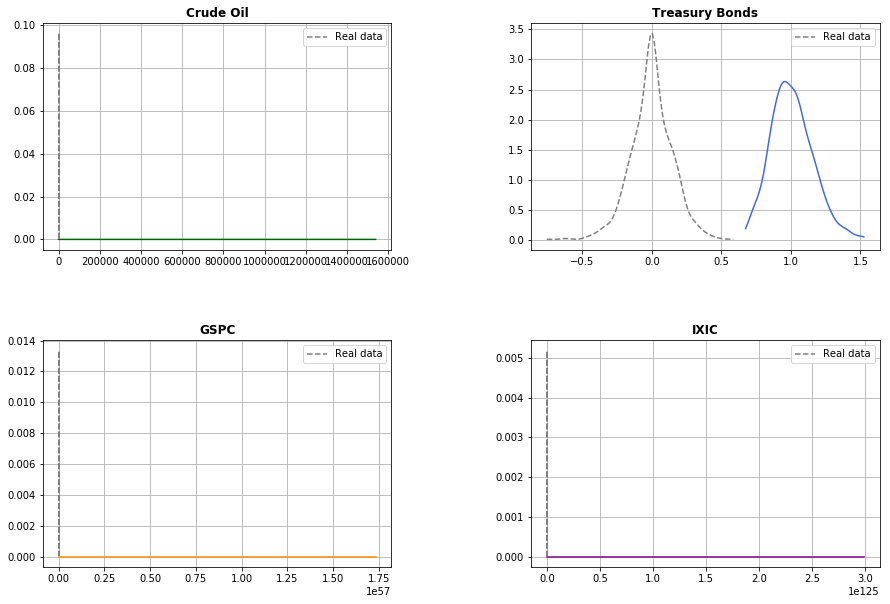

In [56]:
# GENERATE SAMPLES USING THE MULTIVARIATE LOGNORMAL
samples = [[],[],[],[]]
for i in range(0, 1295):
    samples[0].append(np.exp(np.random.multivariate_normal(factorMeans, factorCov)[0]))
    samples[1].append(np.exp(np.random.multivariate_normal(factorMeans, factorCov)[1]))
    samples[2].append(np.exp(np.random.multivariate_normal(factorMeans, factorCov)[2]))
    samples[3].append(np.exp(np.random.multivariate_normal(factorMeans, factorCov)[3]))
    
# SHOW THE RESULTS AND COMPARE WITH REAL DATA
plt.figure(figsize=(15,10))
plotDistribution(samples[0], 2, 2, 1, "Crude Oil", "darkgreen", factorsReturns[0])
plotDistribution(samples[1], 2, 2, 2, "Treasury Bonds", "royalblue", factorsReturns[1])
plotDistribution(samples[2], 2, 2, 3, "GSPC", "darkorange", factorsReturns[2])
plotDistribution(samples[3], 2, 2, 4, "IXIC", "darkmagenta", factorsReturns[3])
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

<div class="alert alert-success">
From the results we can see that the Lognormal Multivariate distribution is not good at allo for our case. None of the factors is fit well.<br>
<br>
However we can try to run the model and see what happens:
</div>

In [57]:
## PARAMETERS ESTIMATION PHASE


# MODEL BUILDING
weights = buildModel(factorsReturns, stocksReturns)

# GET MULTIVARIATE
factorCov = np.cov(factorsReturns)
factorMeans = [sum(fr)/len(fr) for fr in factorsReturns]
sample = np.random.lognormal(factorMeans, factorCov)

# SET PARAMETERS
parallelism = 4
numTrials = 10000
trialIndexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trialIndexes, parallelism)
bFactorWeights = sc.broadcast(weights)

# RUN
trials = seedRDD.flatMap(lambda idx: simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans,
                    factorCov,
                    bFactorWeights,
                    "lognormal"
                ))
trials.cache()

# CALCULATE VaR
valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

# SHOW RESULTS
displayTable(np.matrix(valueAtRisk), ["Value at Risk (VaR) 5%"], "")
displayTable(np.matrix(conditionalValueAtRisk), ["Conditional Value at Risk (CVaR) 5%"], "")



## BACKTESTING PHASE

# GET VaR AND CVaR
varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)

# SHOW VALUES
displayTable(np.matrix(varConfidenceInterval), ["min", "max"], "VaR confidence interval:")
displayTable(np.matrix(cvarConfidenceInterval), ["min", "max"], "CVaR confidence interval:")
displayTable(np.matrix(kupiecTestPValue(stocksReturns, valueAtRisk, 0.05)), ["Kupiec test p-value"], "")

Value at Risk (VaR) 5%
-9.970510e+136


Conditional Value at Risk (CVaR) 5%
-2.238384e+281



VaR confidence interval:


min,max
-1.086992e+137,-1.152281e+138



CVaR confidence interval:


min,max
-1.726950e+281,-1.716527e+281



Number of failures: 0



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Kupiec test p-value
NaN


<div class="alert alert-success">
The model is very bad: the Kupiec test fails encountering also some division by zero. We demonstrated (as clear from the plots done before) that the lognormal is not a good distribution for our data.<br>
</div>

#### 10.2 Triangular distribution

<div class="alert alert-success">
Here we're going to try a triangular distribution. We don't know a priori if the result will be good or not. Let's try.<br>
<br>
First of all we can check - as usual - if the triangular distribution can be good for our model.
</div>

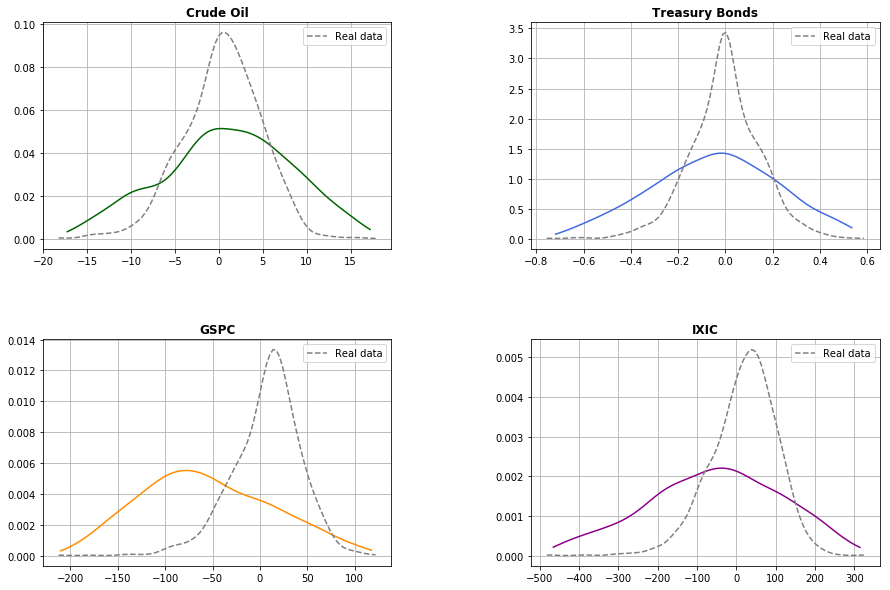

In [58]:
# GET THE PARAMETERS
mins = [min(factor) for factor in factorsReturns]
maxs = [max(factor) for factor in factorsReturns]
modes = [float(mode(factor)[0]) for factor in factorsReturns]

# GENERATE SAMPLES USING THE MULTIVARIATE LOGNORMAL
samples = [[],[],[],[]]
for i in range(0, 1295):
    samples[0].append(np.random.triangular(mins, modes, maxs)[0])
    samples[1].append(np.random.triangular(mins, modes, maxs)[1])
    samples[2].append(np.random.triangular(mins, modes, maxs)[2])
    samples[3].append(np.random.triangular(mins, modes, maxs)[3])
    
# SHOW THE RESULTS AND COMPARE WITH REAL DATA
plt.figure(figsize=(15,10))
plotDistribution(samples[0], 2, 2, 1, "Crude Oil", "darkgreen", factorsReturns[0])
plotDistribution(samples[1], 2, 2, 2, "Treasury Bonds", "royalblue", factorsReturns[1])
plotDistribution(samples[2], 2, 2, 3, "GSPC", "darkorange", factorsReturns[2])
plotDistribution(samples[3], 2, 2, 4, "IXIC", "darkmagenta", factorsReturns[3])
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

<div class="alert alert-success">
From the 4 plots shown above, we can notice that the triangular distribution is not so appropriate for our model. However, it's not as bad as the lognormal! The results can be interesting: we have to try.<br>
<br>
Before running our model, we have to define our new "*simulation function*", which needs *mins*, *maxs* and *modes* of our factors, and not the means and covariance matrix as before:
</div>

In [59]:
# RUN MONTE CARLO SIMULATION WITH TRIANGULAR DISTRIBUTION
def simulateTrialReturnsTR(numTrials, mins, maxs, modes, weights):
    
    trialReturns = []
    
    for i in range(0, numTrials):
        
        # GENERATE SAMPLES OF THE BUILT MODEL
        trialFactorReturns = np.random.triangular(mins, modes, maxs)
            
        # FEATURIZE THE FACTOR RETURNS
        trialFeatures = featurize(trialFactorReturns.tolist())

        # INSERT INTERCEPT
        trialFeatures.insert(0, 1)

        # CALCULATE THE TOTAL RETURN
        trialTotalReturn = 0
        for w in weights.value:
            trialTotalReturn += np.array(w).dot(trialFeatures) # for each stock
        trialReturns.append(trialTotalReturn)
        
    return trialReturns

<div class="alert alert-success">
Now, let's run the simulation!
</div>

In [60]:
## PARAMETERS ESTIMATION PHASE


# MODEL BUILDING
weights = buildModel(factorsReturns, stocksReturns)

# SET PARAMETERS
parallelism = 4
numTrials = 10000
trialIndexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trialIndexes, parallelism)
bFactorWeights = sc.broadcast(weights)

# RUN
trials = seedRDD.flatMap(lambda idx: simulateTrialReturnsTR(
                    max(int(numTrials/parallelism), 1), 
                    mins,
                    maxs,
                    modes,
                    bFactorWeights
                ))
trials.cache()

# CALCULATE VaR
valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

# SHOW RESULTS
displayTable(np.matrix(valueAtRisk), ["Value at Risk (VaR) 5%"], "")
displayTable(np.matrix(conditionalValueAtRisk), ["Conditional Value at Risk (CVaR) 5%"], "")

print()
print()


## BACKTESTING PHASE


# GET VaR AND CVaR
varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)

# SHOW VALUES
displayTable(np.matrix(varConfidenceInterval), ["min", "max"], "VaR confidence interval:")
displayTable(np.matrix(cvarConfidenceInterval), ["min", "max"], "CVaR confidence interval:")
displayTable(np.matrix(kupiecTestPValue(stocksReturns, valueAtRisk, 0.05)), ["Kupiec test p-value"], "")

Value at Risk (VaR) 5%
-3621.609541


Conditional Value at Risk (CVaR) 5%
-4695.707995





VaR confidence interval:


min,max
-3587.889025,-3588.082926



CVaR confidence interval:


min,max
-4674.650233,-4809.164139



Number of failures: 39



Kupiec test p-value
0.000409


<div class="alert alert-success">
The results is astonishingly good! We can see this from the very few failures and the high p-value that the Kupiec test generates. The triangular distribution, which didn't look very promising, demonstrated to be actually good for our data.
</div>

#### 10.3 Laplace Distribution

<div class="alert alert-success">
Now we're going to try the Laplace Distribution:
</div>

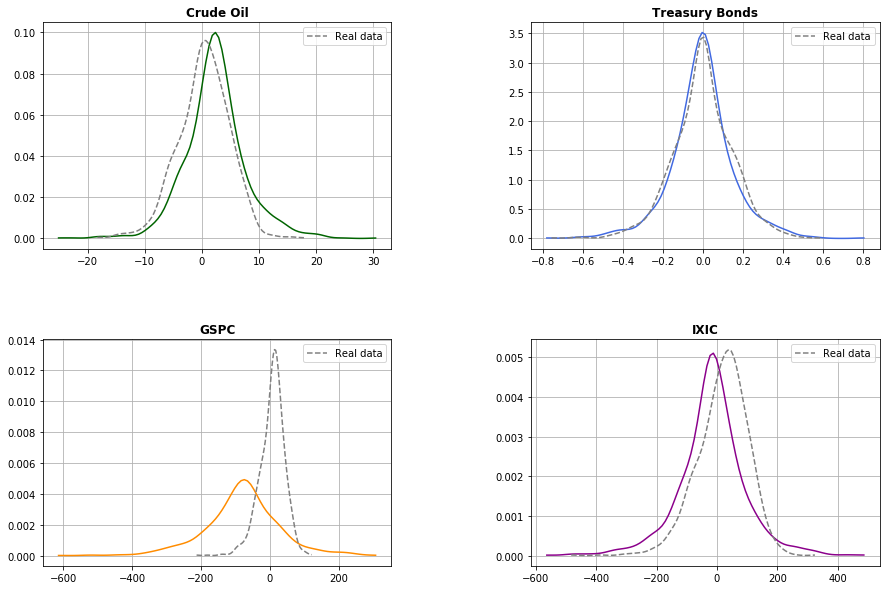

In [61]:
# GET THE PARAMETERS
modes = [float(mode(factor)[0]) for factor in factorsReturns]
disp = [np.sum(abs(item-modes[i]) for item in factorsReturns[i]) for i in range(0, len(factorsReturns))]
scale = np.divide(disp, 1295)

# GENERATE SAMPLES USING THE LAPLACE LOGNORMAL
samples = [[],[],[],[]]
for i in range(0, 1295):
    samples[0].append(np.random.laplace(modes, scale)[0])
    samples[1].append(np.random.laplace(modes, scale)[1])
    samples[2].append(np.random.laplace(modes, scale)[2])
    samples[3].append(np.random.laplace(modes, scale)[3])
    
# SHOW THE RESULTS AND COMPARE WITH REAL DATA
plt.figure(figsize=(15,10))
plotDistribution(samples[0], 2, 2, 1, "Crude Oil", "darkgreen", factorsReturns[0])
plotDistribution(samples[1], 2, 2, 2, "Treasury Bonds", "royalblue", factorsReturns[1])
plotDistribution(samples[2], 2, 2, 3, "GSPC", "darkorange", factorsReturns[2])
plotDistribution(samples[3], 2, 2, 4, "IXIC", "darkmagenta", factorsReturns[3])
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

<div class="alert alert-success">
The results are very promising! Let's check what happens.
</div>

In [62]:
# RUN MONTE CARLO SILMULATION WITH LAPLACE DISTRIBUTION
def simulateTrialReturnsLAP(numTrials, modes, scale, weights):
    
    trialReturns = []
    
    for i in range(0, numTrials):
        
        # GENERATE SAMPLES OF THE BUILT MODEL
        trialFactorReturns = np.random.laplace(modes, scale)
            
        # FEATURIZE THE FACTOR RETURNS
        trialFeatures = featurize(trialFactorReturns.tolist())

        # INSERT INTERCEPT
        trialFeatures.insert(0, 1)

        # CALCULATE THE TOTAL RETURN
        trialTotalReturn = 0
        for w in weights.value:
            trialTotalReturn += np.array(w).dot(trialFeatures) # for each stock
        trialReturns.append(trialTotalReturn)
        
    return trialReturns

In [63]:
## PARAMETERS ESTIMATION


# MODEL BUILDING
weights = buildModel(factorsReturns, stocksReturns)

# SET PARAMETERS
parallelism = 4
numTrials = 10000
trialIndexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trialIndexes, parallelism)
bFactorWeights = sc.broadcast(weights)

# RUN
trials = seedRDD.flatMap(lambda idx: simulateTrialReturnsLAP(
                    max(int(numTrials/parallelism), 1), 
                    modes,
                    scale,
                    bFactorWeights,
                ))
trials.cache()

# CALCULATE VaR
valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

# SHOW RESULTS
displayTable(np.matrix(valueAtRisk), ["Value at Risk (VaR) 5%"], "")
displayTable(np.matrix(conditionalValueAtRisk), ["Conditional Value at Risk (CVaR) 5%"], "")

print()
print()


### BACKTESTING


# GET VaR AND CVaR
varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)

# SHOW VALUES
displayTable(np.matrix(varConfidenceInterval), ["min", "max"], "VaR confidence interval:")
displayTable(np.matrix(cvarConfidenceInterval), ["min", "max"], "CVaR confidence interval:")
displayTable(np.matrix(kupiecTestPValue(stocksReturns, valueAtRisk, 0.05)), ["Kupiec test p-value"], "")

Value at Risk (VaR) 5%
-11392.691129


Conditional Value at Risk (CVaR) 5%
-25674.199113





VaR confidence interval:


min,max
-11173.815391,-11244.891082



CVaR confidence interval:


min,max
-26018.56814,-26247.878973



Number of failures: 35



Kupiec test p-value
0.000035


<div class="alert alert-success">
The results, as expected (having seen the plots before), are great. Only few failures and an high p-value: the Laplace Distribution turned out to fit with our model.
</div>

#### 10.4 Von Mises Distribution

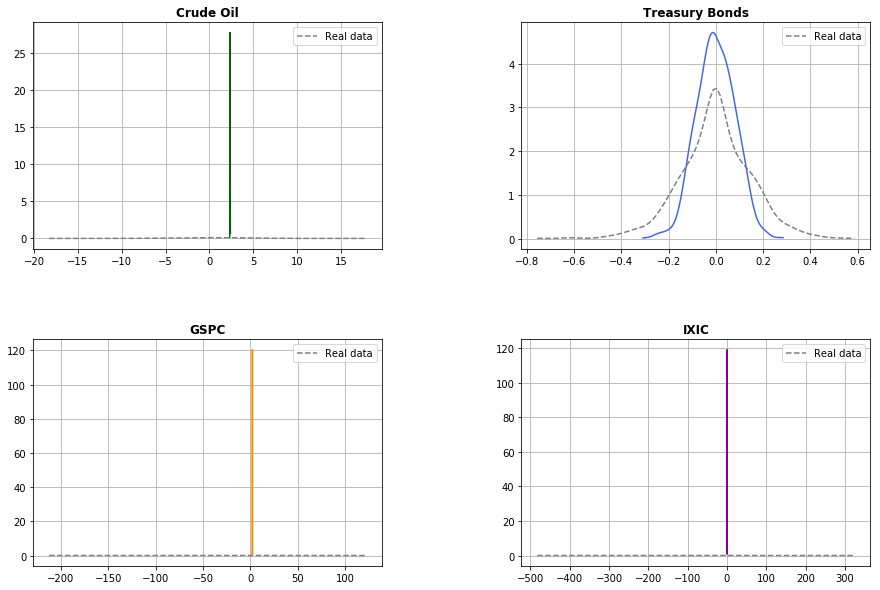

In [112]:
# GET THE PARAMETERS
modes = [float(mode(factor)[0]) for factor in factorsReturns]
disp = [np.sum(abs(item-modes[i]) for item in factorsReturns[i]) for i in range(0, len(factorsReturns))]

# GENERATE SAMPLES USING THE VON MISES DISTRIBUTION
samples = [[],[],[],[]]
for i in range(0, 1295):
    samples[0].append(np.random.vonmises(modes, disp)[0])
    samples[1].append(np.random.vonmises(modes, disp)[1])
    samples[2].append(np.random.vonmises(modes, disp)[2])
    samples[3].append(np.random.vonmises(modes, disp)[3])
    
# SHOW THE RESULTS AND COMPARE WITH REAL DATA
plt.figure(figsize=(15,10))
plotDistribution(samples[0], 2, 2, 1, "Crude Oil", "darkgreen", factorsReturns[0])
plotDistribution(samples[1], 2, 2, 2, "Treasury Bonds", "royalblue", factorsReturns[1])
plotDistribution(samples[2], 2, 2, 3, "GSPC", "darkorange", factorsReturns[2])
plotDistribution(samples[3], 2, 2, 4, "IXIC", "darkmagenta", factorsReturns[3])
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

<div class="alert alert-success">
Doesn't look extremely promising. Let's see if we can get surprised:
</div>

In [113]:
# RUN MONTE CARLO SILMULATION WITH LAPLACE DISTRIBUTION
def simulateTrialReturnsVM(numTrials, modes, disp, weights):
    
    trialReturns = []
    
    for i in range(0, numTrials):
        
        # GENERATE SAMPLES OF THE BUILT MODEL
        trialFactorReturns = np.random.vonmises(modes, disp)
            
        # FEATURIZE THE FACTOR RETURNS
        trialFeatures = featurize(trialFactorReturns.tolist())

        # INSERT INTERCEPT
        trialFeatures.insert(0, 1)

        # CALCULATE THE TOTAL RETURN
        trialTotalReturn = 0
        for w in weights.value:
            trialTotalReturn += np.array(w).dot(trialFeatures) # for each stock
        trialReturns.append(trialTotalReturn)
        
    return trialReturns

In [114]:
# MODEL BUILDING
weights = buildModel(factorsReturns, stocksReturns)

# SET PARAMETERS
parallelism = 4
numTrials = 10000
trialIndexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trialIndexes, parallelism)
bFactorWeights = sc.broadcast(weights)

# RUN
trials = seedRDD.flatMap(lambda idx: simulateTrialReturnsVM(
                    max(int(numTrials/parallelism), 1), 
                    modes,
                    disp,
                    bFactorWeights,
                ))
trials.cache()

# CALCULATE VaR
valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

# SHOW RESULTS
displayTable(np.matrix(valueAtRisk), ["Value at Risk (VaR) 5%"], "")
displayTable(np.matrix(conditionalValueAtRisk), ["Conditional Value at Risk (CVaR) 5%"], "")

print()
print()


### BACKTESTING


# GET VaR AND CVaR
varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)

# SHOW VALUES
displayTable(np.matrix(varConfidenceInterval), ["min", "max"], "VaR confidence interval:")
displayTable(np.matrix(cvarConfidenceInterval), ["min", "max"], "CVaR confidence interval:")
displayTable(np.matrix(kupiecTestPValue(stocksReturns, valueAtRisk, 0.05)), ["Kupiec test p-value"], "")

Value at Risk (VaR) 5%
-99.503529


Conditional Value at Risk (CVaR) 5%
-106.261064





VaR confidence interval:


min,max
-99.03421,-100.630654



CVaR confidence interval:


min,max
-105.622721,-105.992029



Number of failures: 408



Kupiec test p-value
1.868635e-202


<div class="alert alert-success">
As expected having seen the plots, the results is not so good.
</div>

#### 10.5 Gumbel Distribution

<div class="alert alert-success">
Let's try with the last one: the Gumbel distribution.
</div>

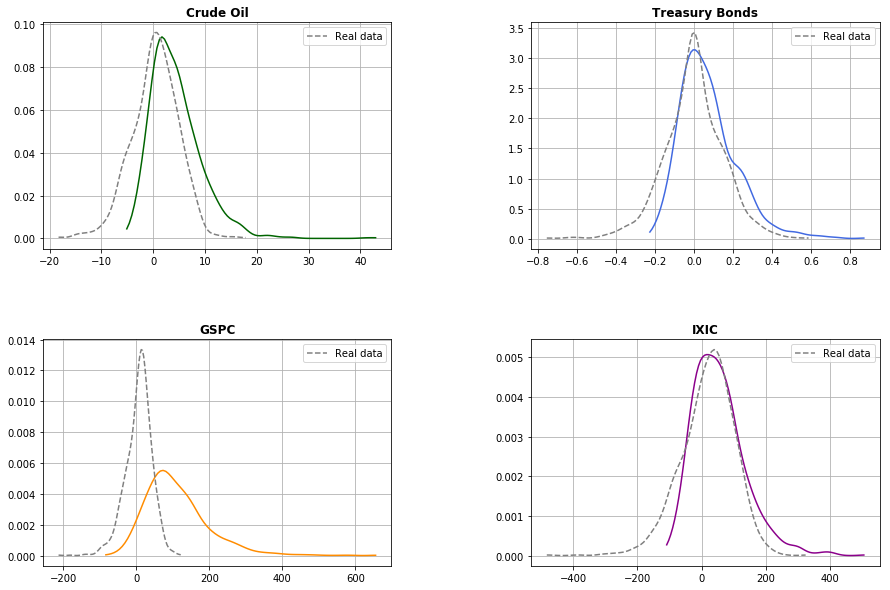

In [115]:
# GET THE PARAMETERS
modes = [abs(float(mode(factor)[0])) for factor in factorsReturns]
disp = [np.sum(abs(item-modes[i]) for item in factorsReturns[i]) for i in range(0, len(factorsReturns))]
scale = np.divide(disp, 1295)

# GENERATE SAMPLES USING THE GUMBEL DISTRIBUTION
samples = [[],[],[],[]]
for i in range(0, 1295):
    samples[0].append(np.random.gumbel(modes, scale)[0])
    samples[1].append(np.random.gumbel(modes, scale)[1])
    samples[2].append(np.random.gumbel(modes, scale)[2])
    samples[3].append(np.random.gumbel(modes, scale)[3])
    
# SHOW THE RESULTS AND COMPARE WITH REAL DATA
plt.figure(figsize=(15,10))
plotDistribution(samples[0], 2, 2, 1, "Crude Oil", "darkgreen", factorsReturns[0])
plotDistribution(samples[1], 2, 2, 2, "Treasury Bonds", "royalblue", factorsReturns[1])
plotDistribution(samples[2], 2, 2, 3, "GSPC", "darkorange", factorsReturns[2])
plotDistribution(samples[3], 2, 2, 4, "IXIC", "darkmagenta", factorsReturns[3])
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

<div class="alert alert-success">
The results are not so bad. Now we have to run the model, and read the results:
</div>

In [117]:
# RUN MONTE CARLO SILMULATION WITH LAPLACE DISTRIBUTION
def simulateTrialReturnsGumbel(numTrials, modes, scale, weights):
    
    trialReturns = []
    
    for i in range(0, numTrials):
        
        # GENERATE SAMPLES OF THE BUILT MODEL
        trialFactorReturns = np.random.gumbel(modes, scale)
            
        # FEATURIZE THE FACTOR RETURNS
        trialFeatures = featurize(trialFactorReturns.tolist())

        # INSERT INTERCEPT
        trialFeatures.insert(0, 1)

        # CALCULATE THE TOTAL RETURN
        trialTotalReturn = 0
        for w in weights.value:
            trialTotalReturn += np.array(w).dot(trialFeatures) # for each stock
        trialReturns.append(trialTotalReturn)
        
    return trialReturns

In [118]:
# MODEL BUILDING
weights = buildModel(factorsReturns, stocksReturns)

# SET PARAMETERS
parallelism = 4
numTrials = 10000
trialIndexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trialIndexes, parallelism)
bFactorWeights = sc.broadcast(weights)

# RUN
trials = seedRDD.flatMap(lambda idx: simulateTrialReturnsGumbel(
                    max(int(numTrials/parallelism), 1), 
                    modes,
                    scale,
                    bFactorWeights,
                ))
trials.cache()

# CALCULATE VaR
valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

# SHOW RESULTS
displayTable(np.matrix(valueAtRisk), ["Value at Risk (VaR) 5%"], "")
displayTable(np.matrix(conditionalValueAtRisk), ["Conditional Value at Risk (CVaR) 5%"], "")

print()
print()


### BACKTESTING


# GET VaR AND CVaR
varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)

# SHOW VALUES
displayTable(np.matrix(varConfidenceInterval), ["min", "max"], "VaR confidence interval:")
displayTable(np.matrix(cvarConfidenceInterval), ["min", "max"], "CVaR confidence interval:")
displayTable(np.matrix(kupiecTestPValue(stocksReturns, valueAtRisk, 0.05)), ["Kupiec test p-value"], "")

Value at Risk (VaR) 5%
-1733.084993


Conditional Value at Risk (CVaR) 5%
-3941.599205





VaR confidence interval:


min,max
-1727.272277,-1727.272277



CVaR confidence interval:


min,max
-3953.087818,-4174.380088



Number of failures: 60



Kupiec test p-value
0.539957


<div class="alert alert-success">
Not so bad! The Gumbel Distribution seems to be good for our data.
</div>

## 10.3 Comparison

<div class="alert alert-success">
In the following section we'll run a set of comparisons between the models built with different statistical distribution, and we're going to compare them graphically. Let's see what we'll obtain!
</div>

In [81]:
def kupiecTestPValueMOD(stocksReturns, valueAtRisk, confidenceLevel):
    
    failures = countFailures(stocksReturns, valueAtRisk)
    N = len(stocksReturns)
    # print("Number of failures:", failures)
    total = len(stocksReturns[0])
    testStatistic = kupiecTestStatistic(total, failures, confidenceLevel)
    # return 1 - stats.chi2.cdf(testStatistic, 1.0)
    return stats.chi2.sf(testStatistic, 1.0), failures


def runTriangular():
    
    # MODEL BUILDING
    weights = buildModel(factorsReturns, stocksReturns)

    # GET MIN, MAX AND MODE
    mins = [min(factor) for factor in factorsReturns]
    maxs = [max(factor) for factor in factorsReturns]
    modes = [float(mode(factor)[0]) for factor in factorsReturns]

    # TEST TRIANGULAR DISTRIBUTION
    sample = np.random.triangular(mins, modes, maxs)

    # SET PARAMETERS
    parallelism = 4
    numTrials = 10000
    trialIndexes = list(range(0, parallelism))
    seedRDD = sc.parallelize(trialIndexes, parallelism)
    bFactorWeights = sc.broadcast(weights)

    # RUN
    trials = seedRDD.flatMap(lambda idx: simulateTrialReturnsTR(
                        max(int(numTrials/parallelism), 1), 
                        mins,
                        maxs,
                        modes,
                        bFactorWeights
                    ))
    trials.cache()

    # CALCULATE VaR
    valueAtRisk = fivePercentVaR(trials)
    conditionalValueAtRisk = fivePercentCVaR(trials)
    return kupiecTestPValueMOD(stocksReturns, valueAtRisk, 0.05)


def runVonmises():
    # MODEL BUILDING
    weights = buildModel(factorsReturns, stocksReturns)

    # GET THE VONMISES PARAMETERS
    modes = [float(mode(factor)[0]) for factor in factorsReturns]
    disp = np.sum(abs(np.subtract([np.mean(fr) for fr in factorsReturns], modes)))

    # SET PARAMETERS
    parallelism = 4
    numTrials = 10000
    trialIndexes = list(range(0, parallelism))
    seedRDD = sc.parallelize(trialIndexes, parallelism)
    bFactorWeights = sc.broadcast(weights)

    # RUN
    trials = seedRDD.flatMap(lambda idx: simulateTrialReturnsVM(
                        max(int(numTrials/parallelism), 1), 
                        modes,
                        disp,
                        bFactorWeights,
                    ))
    trials.cache()

    # CALCULATE VaR
    valueAtRisk = fivePercentVaR(trials)
    conditionalValueAtRisk = fivePercentCVaR(trials)
    return kupiecTestPValueMOD(stocksReturns, valueAtRisk, 0.05)


def runMultivariate():
    
    # MODEL BUILDING
    weights = buildModel(factorsReturns, stocksReturns)

    # GET MULTIVARIATE
    factorCov = np.cov(factorsReturns)
    factorMeans = [sum(fr)/len(fr) for fr in factorsReturns]
    sample = np.random.multivariate_normal(factorMeans, factorCov)

    # SET PARAMETERS
    parallelism = 4
    numTrials = 10000
    trialIndexes = list(range(0, parallelism))
    seedRDD = sc.parallelize(trialIndexes, parallelism)
    bFactorWeights = sc.broadcast(weights)

    # RUN
    trials = seedRDD.flatMap(lambda idx: simulateTrialReturns(
                        max(int(numTrials/parallelism), 1), 
                        factorMeans,
                        factorCov,
                        bFactorWeights,
                    ))
    trials.cache()

    # CALCULATE VaR
    valueAtRisk = fivePercentVaR(trials)
    conditionalValueAtRisk = fivePercentCVaR(trials)
    return kupiecTestPValueMOD(stocksReturns, valueAtRisk, 0.05)

In [82]:
testingValues = [10, 25, 50, 100, 150, 250, 500, 1000]
multivariatePValues = []
multivariateNbFailures = []
triangularPValues = []
triangularNbFailures = []
vonmisesPValues = []
vonmisesNbFailures = []

for value in testingValues:
    
    # LOAD RAW DATA
    rawStocks = loadRawStocks(value)
    # allFactors is already loaded

    # LOAD PROCESSED DATA
    stocks, factors = loadStocks(rawStocks, allFactors, start, end)

    # CALCULATE RETURNS
    stocksReturns = list(map(twoWeekReturns, stocks))
    factorsReturns = list(map(twoWeekReturns, factors))
    
    pValue, nbFailures = runMultivariate()
    multivariatePValues.append(pValue)
    multivariateNbFailures.append(nbFailures)
    
    pValue, nbFailures = runTriangular()
    triangularPValues.append(pValue)
    triangularNbFailures.append(nbFailures)
    
    pValue, nbFailures = runVonmises()
    vonmisesPValues.append(pValue)
    vonmisesNbFailures.append(nbFailures)

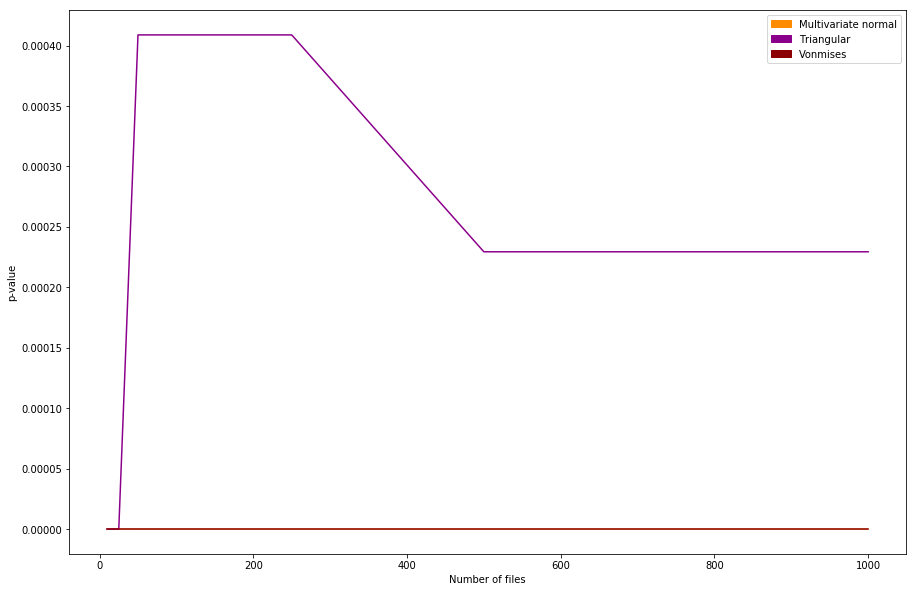

In [83]:
plt.figure(figsize=(15,10))
plt.plot(testingValues , multivariatePValues, color="darkorange", alpha=0.7)
plt.plot(testingValues , triangularPValues, color="darkmagenta")
plt.plot(testingValues , vonmisesPValues, color="darkred")

plt.xlabel("Number of files")
plt.ylabel("p-value")

magenta_patch = mpatches.Patch(color='darkmagenta', label='Triangular')
orange_patch = mpatches.Patch(color='darkorange', label='Multivariate normal')
red_patch = mpatches.Patch(color='darkred', label='Vonmises')
plt.legend(handles=[orange_patch, magenta_patch, red_patch])

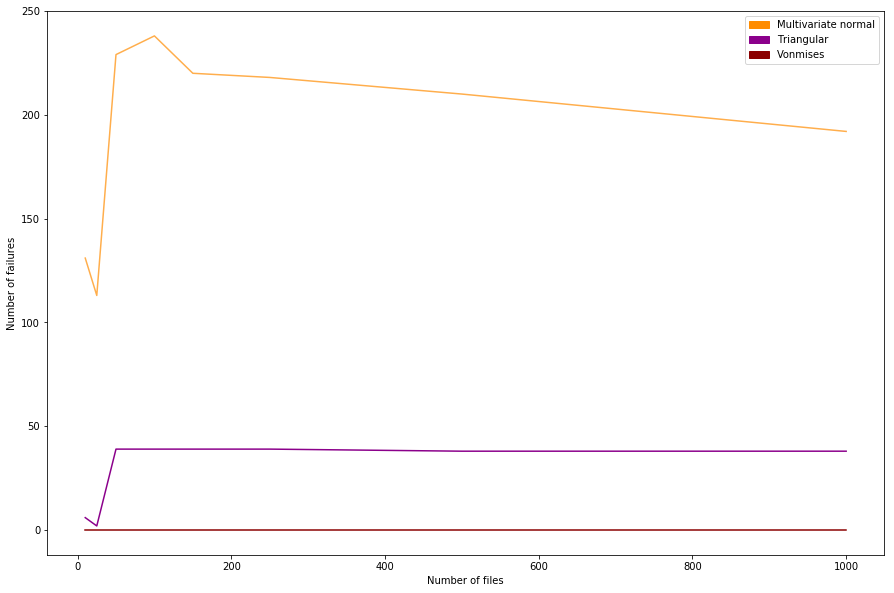

In [84]:
plt.figure(figsize=(15,10))
plt.plot(testingValues , multivariateNbFailures, color="darkorange", alpha=0.7)
plt.plot(testingValues , triangularNbFailures, color="darkmagenta")
plt.plot(testingValues , vonmisesPValues, color="darkred")

plt.xlabel("Number of files")
plt.ylabel("Number of failures")

magenta_patch = mpatches.Patch(color='darkmagenta', label='Triangular')
orange_patch = mpatches.Patch(color='darkorange', label='Multivariate normal')
red_patch = mpatches.Patch(color='darkred', label='Vonmises')
plt.legend(handles=[orange_patch, magenta_patch, red_patch])

# 6. Summary
In this lecture, we studied the Monte Carlo Simulation method and its application to estimate financial risk. To apply it, first, we needed to define the relationship between market factors and the instruments' returns. In such step, you must define the model which maps the market factors' values to the instruments' values: in our use case, we used a linear regression function for building our model. Next, we also had to find the parameters of our model, which are the weights of the factors we considered. Then, we had to study the distribution of each market factor. A good way to do that is using Kernel density estimation to smooth the distribution and plot it. Depending on the shape of each figure, we had to guess the best fit distribution for each factor: in our use case, we used a very simple approach, and decided that our smoothed distributions all looked normal distributions. 

Then, the idea of Monte Carlo simulation was to generate many possible values for each factor and calculate the corresponding outcomes by a well-defined model in each trial. After many trials, we were able to calculate VaR from the sequences of outcome's values. When the number of trials is large enough, the VaR converges to reasonable values, that we could validate using well-known statistical hypothesis. 

# References
- The example in section 2 is inspired from [this article](http://www.solver.com/monte-carlo-simulation-example).
- [Backtesting Value-at-Risk models](https://aaltodoc.aalto.fi/bitstream/handle/123456789/181/hse_ethesis_12049.pdf?sequence=1) (Kansantaloustiede, 2009) - (A good reference to study Backtesting).
